In [5]:
%load_ext autoreload
%autoreload 2

import helper
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Cropping2D, Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dropout, Dense
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import keras.backend as k
from keras.initializers import TruncatedNormal
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import h5py
import pdb

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


# Read in data, format, & visualize

In [6]:
emotion_dict = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
image_shape = (48,48,1)
n_classes = len(emotion_dict)
n_features = np.product(image_shape)

In [7]:
# read in data
file_path = './Data/Kaggle-FER/fer2013.csv'
data_raw = helper.read_in_data(file_path) # data is a tuple of (x_list, y_list, usage_list)

In [8]:
# convert data to numpy array
data_formatted = helper.format(data_raw, image_shape, n_classes) # return tuple of (x_array, y_array, usage_list)

In [9]:
# number of example for each class
label, count = np.unique(data_formatted[1], return_counts=True)
dict(zip(label, count))

{0: 4945, 1: 547, 2: 5121, 3: 8988, 4: 6076, 5: 4001, 6: 6197}

In [10]:
# split into train & test sets. Test set = public, private set is used for final testing, to be consistent with the competition
(x_train, y_train), (x_test, y_test), (x_private, y_private) = helper.create_train_test(data_formatted, n_classes)

# take a sample

In [21]:
# # take a random sample
# n_sample = 100

# x_train = x_train[0:n_sample]
# y_train = y_train[0:n_sample]
# x_test = x_test[0:n_sample]
# y_test = y_test[0:n_sample]
# x_private = x_private[0:n_sample]
# y_private = y_private[0:n_sample]

In [22]:
# select certain class
selected_classes = [3,4]
n_sample = 50

mask = np.isin(y_train, selected_classes).reshape(-1)
# print('mask shape', mask.shape)
x_train = x_train[mask][0:n_sample]
y_train = y_train[mask][0:n_sample]

mask = np.isin(y_test, selected_classes).reshape(-1)
x_test = x_test[mask][0:n_sample]
y_test = y_test[mask][0:n_sample]

In [23]:
# distribution for each class
label, count = np.unique(y_train, return_counts=True)
print('training set', dict(zip(label, count)))

# distribution for each class
label, count = np.unique(y_test, return_counts=True)
print('validation set', dict(zip(label, count)))

training set {3: 30, 4: 20}
validation set {3: 32, 4: 18}


# Build model & train

In [11]:
# one-hot encode
y_train_onehot = keras.utils.to_categorical(y_train, n_classes)
y_test_onehot = keras.utils.to_categorical(y_test, n_classes)
y_private_onehot = keras.utils.to_categorical(y_private, n_classes)

In [12]:
print(x_train.shape)
print(y_train.shape)
print(y_train_onehot.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test_onehot.shape)
print(x_private.shape)
print(y_private.shape)
print(y_private_onehot.shape)

(28698, 48, 48, 1)
(28698, 1)
(28698, 7)
(3588, 48, 48, 1)
(3588, 1)
(3588, 7)
(3589, 48, 48, 1)
(3589, 1)
(3589, 7)


In [13]:
# hyperparameters
epochs = 10
batch_size = 256
n_train = len(x_train)
n_test = len(x_test)

# 1st place model

## featurewise, flip

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 3s - loss: 0.6529 - acc: 0.7633 - val_loss: 1.1233 - val_acc: 0.6179
Epoch 54/200
111/112 [============================>.] - ETA: 0s - loss: 0.6409 - acc: 0.7689Epoch 00053: val_loss did not improve

Epoch 00053: reducing learning rate to 0.0012499999720603228.
112/112 [==============================] - 3s - loss: 0.6409 - acc: 0.7690 - val_loss: 1.1528 - val_acc: 0.6203
Epoch 55/200
112/112 [==============================] - 4s - loss: 0.6325 - acc: 0.7733 - val_loss: 1.1476 - val_acc: 0.6113


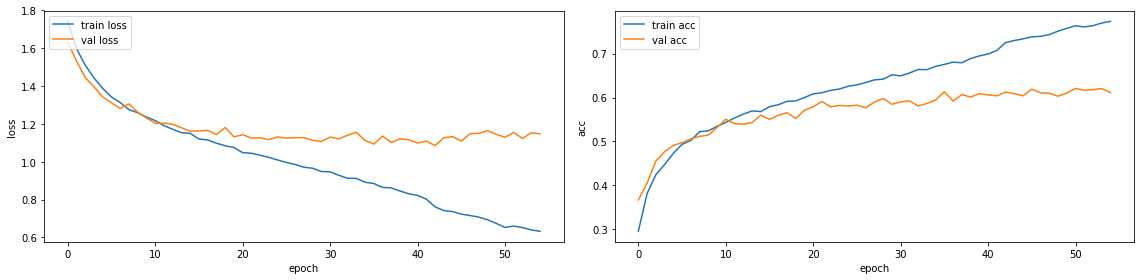

In [67]:
file_name = './Model/1st_place_featurewise_flip.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

In [68]:
# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

[1.0769642372130053, 0.63067783056438598]


## featurewise, flip 2nd run

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 3s - loss: 0.6603 - acc: 0.7597 - val_loss: 1.1395 - val_acc: 0.6068
Epoch 53/200
112/112 [==============================] - 4s - loss: 0.6431 - acc: 0.7676 - val_loss: 1.1561 - val_acc: 0.6119
Epoch 54/200
112/112 [==============================] - 4s - loss: 0.6378 - acc: 0.7703 - val_loss: 1.1453 - val_acc: 0.6146
Epoch 55/200
112/112 [==============================] - 3s - loss: 0.6402 - acc: 0.7723 - val_loss: 1.1684 - val_acc: 0.6047
Epoch 56/200
110/112 [============================>.] - ETA: 0s - loss: 0.6293 - acc: 0.7716Epoch 00055: val_loss did not improve

Epoch 00055: reducing learning rate to 0.0012499999720603228.
112/112 [==============================] - 4s - loss: 0.6287 - acc: 0.7717 - val_loss: 1.1360 - val_acc: 0.6107
Epoch 57/200
112/112 [==============================] - 4s - loss: 0.6179 - acc: 0.7793 - val_loss: 1.1408 - val_acc: 0.6152
[1.0906291693129444, 0.62573242587797395]


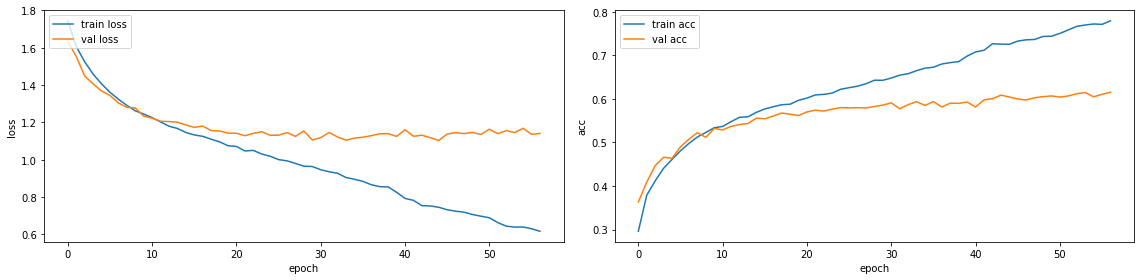

In [76]:
file_name = './Model/1st_place_featurewise_flip.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_loss',verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## featurewise, flip, monitor=val_acc

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/200
112/112 [==============================] - 4s - loss: 1.7035 - acc: 0.3103 - val_loss: 1.5463 - val_acc: 0.4043
Epoch 2/200
112/112 [==============================] - 4s - loss: 1.5238 - acc: 0.4103 - val_loss: 1.3963 - val_acc: 0.4703
Epoch 3/200
112/112 [==============================] - 4s - loss: 1.4079 - acc: 0.4619 - val_loss: 1.3338 - val_acc: 0.4898
Epoch 4/200
112/112 [==============================] - 4s - loss: 1.3432 - acc: 0.4854 - val_loss: 1.2839 - val_acc: 0.4976
Epoch 5/200
112/112 [==============================] - 4s - loss: 1.2738 - acc: 0.5126 - val_loss: 1.2207 - val_acc: 0.5342
Epoch 6/200
112/112 [==============================] - 4s - loss: 1.2215 - acc: 0.5348 - val_loss: 1.1945 - val_acc: 0.5573
Epoch 7/200
112/112 [==============================] - 3s - loss: 1.1756 - acc: 0.5544 - val_loss: 1.1740 - val_acc: 0.5579
Epoch 8/200
112/112 [==============================] - 4s - loss: 1.1442 - acc: 0.5649 - val_loss: 1.1646 - val_acc: 0.5651
Epoch 9/

112/112 [==============================] - 4s - loss: 0.4006 - acc: 0.8610 - val_loss: 1.6182 - val_acc: 0.5645
Epoch 31/200
111/112 [============================>.] - ETA: 0s - loss: 0.3990 - acc: 0.8616Epoch 00030: val_acc did not improve

Epoch 00030: reducing learning rate to 0.05000000074505806.
112/112 [==============================] - 4s - loss: 0.3983 - acc: 0.8619 - val_loss: 1.5574 - val_acc: 0.5606
Epoch 32/200
112/112 [==============================] - 3s - loss: 0.2784 - acc: 0.9050 - val_loss: 1.5570 - val_acc: 0.5849
Epoch 33/200
112/112 [==============================] - 3s - loss: 0.2136 - acc: 0.9275 - val_loss: 1.6696 - val_acc: 0.5885
Epoch 34/200
112/112 [==============================] - 3s - loss: 0.1828 - acc: 0.9394 - val_loss: 1.6393 - val_acc: 0.5927
Epoch 35/200
112/112 [==============================] - 3s - loss: 0.1610 - acc: 0.9465 - val_loss: 1.7890 - val_acc: 0.5861
Epoch 36/200
112/112 [==============================] - 3s - loss: 0.1505 - acc: 0.951

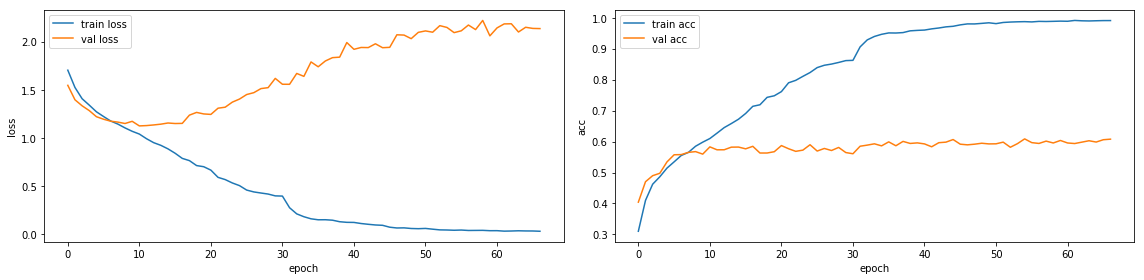

In [69]:
file_name = './Model/1st_place_featurewise_flip_valacc.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

# model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True, lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_acc', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_acc', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

In [71]:
# continue training
# callbacks
early_stopper = EarlyStopping(monitor='val_acc', patience=31)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

Epoch 1/200
112/112 [==============================] - 4s - loss: 0.0254 - acc: 0.9927 - val_loss: 2.1936 - val_acc: 0.6049
Epoch 2/200
112/112 [==============================] - 3s - loss: 0.0263 - acc: 0.9919 - val_loss: 2.1304 - val_acc: 0.6068
Epoch 3/200
112/112 [==============================] - 3s - loss: 0.0267 - acc: 0.9926 - val_loss: 2.1643 - val_acc: 0.6041
Epoch 4/200
112/112 [==============================] - 3s - loss: 0.0244 - acc: 0.9930 - val_loss: 2.1914 - val_acc: 0.5999
Epoch 5/200
112/112 [==============================] - 3s - loss: 0.0257 - acc: 0.9922 - val_loss: 2.2448 - val_acc: 0.6002
Epoch 6/200
112/112 [==============================] - 3s - loss: 0.0253 - acc: 0.9932 - val_loss: 2.1978 - val_acc: 0.6020
Epoch 7/200
112/112 [==============================] - 3s - loss: 0.0270 - acc: 0.9914 - val_loss: 2.1585 - val_acc: 0.6074
Epoch 8/200
112/112 [==============================] - 3s - loss: 0.0279 - acc: 0.9915 - val_loss: 2.2167 - val_acc: 0.6002
Epoch 9/

KeyboardInterrupt: 

## featurewise, flip, monitor=val_loss+val_acc

In [68]:
# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

[1.0769642372130053, 0.63067783056438598]


c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/200
112/112 [==============================] - 4s - loss: 1.6754 - acc: 0.3259 - val_loss: 1.5066 - val_acc: 0.4155
Epoch 2/200
112/112 [==============================] - 4s - loss: 1.6109 - acc: 0.3717 - val_loss: 1.4267 - val_acc: 0.4469
Epoch 3/200
112/112 [==============================] - 4s - loss: 1.4373 - acc: 0.4491 - val_loss: 1.3551 - val_acc: 0.4922
Epoch 4/200
112/112 [==============================] - 4s - loss: 1.3443 - acc: 0.4851 - val_loss: 1.2750 - val_acc: 0.5132
Epoch 5/200
112/112 [==============================] - 4s - loss: 1.2795 - acc: 0.5106 - val_loss: 1.2559 - val_acc: 0.5300
Epoch 6/200
112/112 [==============================] - 3s - loss: 1.2429 - acc: 0.5276 - val_loss: 1.2307 - val_acc: 0.5252
Epoch 7/200
112/112 [==============================] - 4s - loss: 1.2083 - acc: 0.5422 - val_loss: 1.2179 - val_acc: 0.5363
Epoch 8/200
112/112 [==============================] - 4s - loss: 1.1615 - acc: 0.5599 - val_loss: 1.1769 - val_acc: 0.5501
Epoch 9/

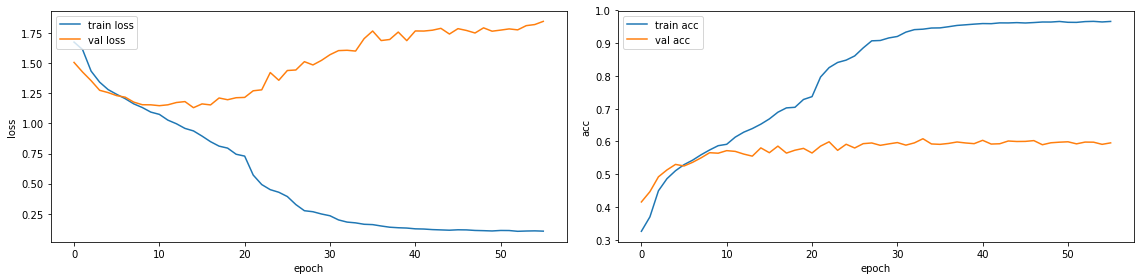

In [72]:
file_name = './Model/1st_place_featurewise_flip_vallossacc.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

# model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True, lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_acc', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_acc', patience=21)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## featurewise, flip, monitor=val_loss+val_acc, lr=0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7282 - acc: 0.3060 - val_loss: 1.6143 - val_acc: 0.3761
Epoch 2/200
112/112 [==============================] - 4s - loss: 1.5858 - acc: 0.3894 - val_loss: 1.5133 - val_acc: 0.4205
Epoch 3/200
112/112 [==============================] - 4s - loss: 1.4983 - acc: 0.4300 - val_loss: 1.4517 - val_acc: 0.4470
Epoch 4/200
112/112 [==============================] - 4s - loss: 1.4286 - acc: 0.4578 - val_loss: 1.3478 - val_acc: 0.4787
Epoch 5/200
112/112 [==============================] - 4s - loss: 1.3702 - acc: 0.4796 - val_loss: 1.3205 - val_acc: 0.5069
Epoch 6/200
112/112 [==============================] - 4s - loss: 1.3270 - acc: 0.4981 - val_loss: 1.3164 - val_acc: 0.5042
Epoch 7/200
112/112 [==============================] - 4s - loss: 1.3034 - acc: 0.5092 - val_loss: 1.2693 - val_acc: 0.5084
Epoch 8/200
112/112 [==============================] - 4s - loss: 1.2620 - acc: 0.5267 - val_loss: 1.2598 - val_acc: 0.5054
Epoch 9/

112/112 [==============================] - 4s - loss: 0.6359 - acc: 0.7726 - val_loss: 1.1381 - val_acc: 0.6146
Epoch 58/200
112/112 [==============================] - 4s - loss: 0.6410 - acc: 0.7707 - val_loss: 1.1354 - val_acc: 0.6140
Epoch 59/200
112/112 [==============================] - 3s - loss: 0.6241 - acc: 0.7766 - val_loss: 1.1575 - val_acc: 0.6149
Epoch 60/200
112/112 [==============================] - 3s - loss: 0.6326 - acc: 0.7704 - val_loss: 1.1458 - val_acc: 0.6166
Epoch 61/200
111/112 [============================>.] - ETA: 0s - loss: 0.6307 - acc: 0.7737Epoch 00060: val_acc improved from 0.62005 to 0.62095, saving model to ./Model/1st_place_featurewise_flip_vallossacc_lr0.01.hdf5

Epoch 00060: reducing learning rate to 0.0003124999930150807.
112/112 [==============================] - 4s - loss: 0.6302 - acc: 0.7737 - val_loss: 1.1249 - val_acc: 0.6209
Epoch 62/200
112/112 [==============================] - 3s - loss: 0.6210 - acc: 0.7751 - val_loss: 1.1343 - val_acc:

112/112 [==============================] - 4s - loss: 0.5978 - acc: 0.7867 - val_loss: 1.1560 - val_acc: 0.6116
Epoch 91/200
112/112 [==============================] - 4s - loss: 0.6123 - acc: 0.7829 - val_loss: 1.1523 - val_acc: 0.6119
Epoch 92/200
112/112 [==============================] - 3s - loss: 0.6083 - acc: 0.7821 - val_loss: 1.1291 - val_acc: 0.6197
[1.0827983114478965, 0.62654849925710354]


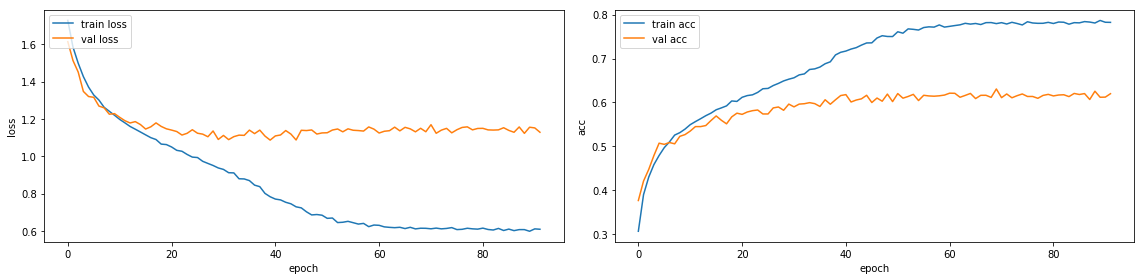

In [73]:
file_name = './Model/1st_place_featurewise_flip_vallossacc_lr0.01.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

# model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_acc', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_acc', patience=21)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## featurewise, flip, monitor=val_loss, lr=0.01

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7421 - acc: 0.2960 - val_loss: 1.6196 - val_acc: 0.3820
Epoch 2/200
112/112 [==============================] - 4s - loss: 1.5922 - acc: 0.3795 - val_loss: 1.5069 - val_acc: 0.4337
Epoch 3/200
112/112 [==============================] - 4s - loss: 1.5064 - acc: 0.4242 - val_loss: 1.4434 - val_acc: 0.4526
Epoch 4/200
112/112 [==============================] - 4s - loss: 1.4332 - acc: 0.4548 - val_loss: 1.3901 - val_acc: 0.4715
Epoch 5/200
112/112 [==============================] - 4s - loss: 1.3796 - acc: 0.4732 - val_loss: 1.3443 - val_acc: 0.4943
Epoch 6/200
112/112 [==============================] - 4s - loss: 1.3366 - acc: 0.4912 - val_loss: 1.3133 - val_acc: 0.5093
Epoch 7/200
112/112 [==============================] - 4s - loss: 1.3061 - acc: 0.5050 - val_loss: 1.2842 - val_acc: 0.5138
Epoch 8/200
112/112 [==============================] - 4s - loss: 1.2647 - acc: 0.5201 - val_loss: 1.2612 - val_acc: 0.5229
Epoch 9/

112/112 [==============================] - 4s - loss: 0.7382 - acc: 0.7324 - val_loss: 1.0842 - val_acc: 0.6230
Epoch 60/200
112/112 [==============================] - 3s - loss: 0.7343 - acc: 0.7317 - val_loss: 1.1075 - val_acc: 0.6089
Epoch 61/200
112/112 [==============================] - 3s - loss: 0.7441 - acc: 0.7297 - val_loss: 1.1045 - val_acc: 0.6107
Epoch 62/200
112/112 [==============================] - 4s - loss: 0.7374 - acc: 0.7354 - val_loss: 1.0904 - val_acc: 0.6137
Epoch 63/200
112/112 [==============================] - 4s - loss: 0.7344 - acc: 0.7328 - val_loss: 1.0941 - val_acc: 0.6169
Epoch 64/200
111/112 [============================>.] - ETA: 0s - loss: 0.7356 - acc: 0.7362Epoch 00063: val_loss did not improve

Epoch 00063: reducing learning rate to 0.00015624999650754035.
112/112 [==============================] - 3s - loss: 0.7357 - acc: 0.7360 - val_loss: 1.1244 - val_acc: 0.6098
Epoch 65/200
112/112 [==============================] - 4s - loss: 0.7357 - acc: 0

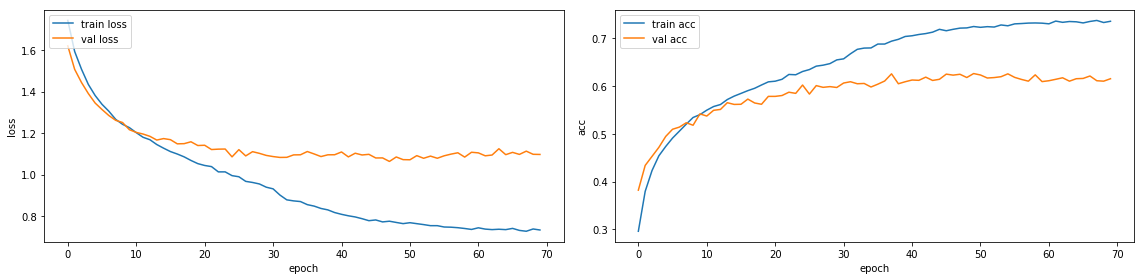

In [74]:
file_name = './Model/1st_place_featurewise_flip_valloss_lr0.01.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

# model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_loss', verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=21)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## featurewise, flip, seed, regularizer

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 4s - loss: 1.3827 - acc: 0.5572 - val_loss: 1.4155 - val_acc: 0.5390
Epoch 51/200
112/112 [==============================] - 4s - loss: 1.3781 - acc: 0.5627 - val_loss: 1.4119 - val_acc: 0.5456
Epoch 52/200
112/112 [==============================] - 4s - loss: 1.3758 - acc: 0.5628 - val_loss: 1.4183 - val_acc: 0.5411
Epoch 53/200
112/112 [==============================] - 4s - loss: 1.3778 - acc: 0.5628 - val_loss: 1.4056 - val_acc: 0.5489
Epoch 54/200
112/112 [==============================] - 4s - loss: 1.3724 - acc: 0.5603 - val_loss: 1.4206 - val_acc: 0.5342
Epoch 55/200
112/112 [==============================] - 4s - loss: 1.3720 - acc: 0.5625 - val_loss: 1.4162 - val_acc: 0.5393
Epoch 56/200
112/112 [==============================] - 4s - loss: 1.3730 - acc: 0.5653 - val_loss: 1.4174 - val_acc: 0.5510
Epoch 57/200
112/112 [==============================] - 4s - loss: 1.3768 - acc: 0.5603 - val_loss: 1.4182 - val_acc: 0.5384
Epoch 58/200


112/112 [==============================] - 4s - loss: 1.3416 - acc: 0.5831 - val_loss: 1.3917 - val_acc: 0.5510
Epoch 82/200
112/112 [==============================] - 4s - loss: 1.3452 - acc: 0.5819 - val_loss: 1.4095 - val_acc: 0.5507
Epoch 83/200
112/112 [==============================] - 4s - loss: 1.3359 - acc: 0.5857 - val_loss: 1.3914 - val_acc: 0.5591
Epoch 84/200
112/112 [==============================] - 4s - loss: 1.3344 - acc: 0.5848 - val_loss: 1.3926 - val_acc: 0.5534
Epoch 85/200
110/112 [============================>.] - ETA: 0s - loss: 1.3433 - acc: 0.5833Epoch 00084: val_loss did not improve

Epoch 00084: reducing learning rate to 0.0003124999930150807.
112/112 [==============================] - 4s - loss: 1.3418 - acc: 0.5839 - val_loss: 1.4156 - val_acc: 0.5486
Epoch 86/200
112/112 [==============================] - 4s - loss: 1.3348 - acc: 0.5824 - val_loss: 1.3901 - val_acc: 0.5597
[1.3626916784549383, 0.57032104328474886]


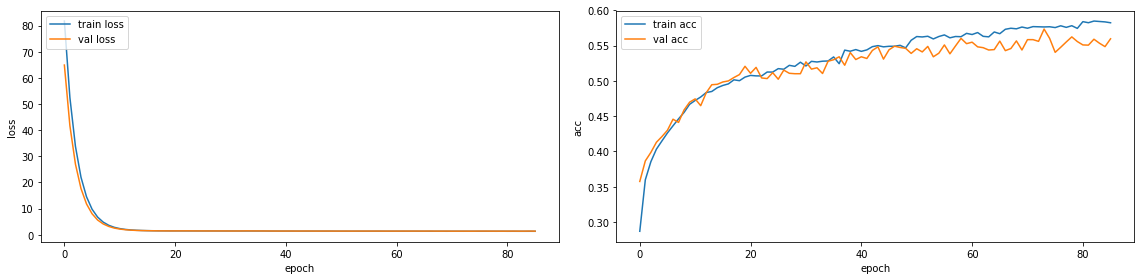

In [77]:
file_name = './Model/1st_place_featurewise_flip_seed_reg.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
# initializer
truncated_normal = TruncatedNormal(seed=0)

# model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer=truncated_normal
                , kernel_regularizer=regularizers.l2(0.01), name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer=truncated_normal, name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_loss',verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## featurewise, flip, seed, regularizer, val_acc

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 4s - loss: 1.4760 - acc: 0.5109 - val_loss: 1.4543 - val_acc: 0.5219
Epoch 23/200
112/112 [==============================] - 4s - loss: 1.4761 - acc: 0.5091 - val_loss: 1.4730 - val_acc: 0.5114
Epoch 24/200
111/112 [============================>.] - ETA: 0s - loss: 1.4724 - acc: 0.5113Epoch 00023: val_acc did not improve

Epoch 00023: reducing learning rate to 0.004999999888241291.
112/112 [==============================] - 4s - loss: 1.4732 - acc: 0.5111 - val_loss: 1.4792 - val_acc: 0.5144
Epoch 25/200
112/112 [==============================] - 4s - loss: 1.4407 - acc: 0.5270 - val_loss: 1.4499 - val_acc: 0.5225
Epoch 26/200
112/112 [==============================] - 4s - loss: 1.4383 - acc: 0.5246 - val_loss: 1.4593 - val_acc: 0.5060
Epoch 27/200
112/112 [==============================] - 4s - loss: 1.4418 - acc: 0.5238 - val_loss: 1.4419 - val_acc: 0.5225
Epoch 28/200
112/112 [==============================] - 4s - loss: 1.4355 - acc: 0.52

112/112 [==============================] - 4s - loss: 1.3788 - acc: 0.5606 - val_loss: 1.4312 - val_acc: 0.5393
Epoch 54/200
112/112 [==============================] - 4s - loss: 1.3728 - acc: 0.5651 - val_loss: 1.4107 - val_acc: 0.5423
Epoch 55/200
112/112 [==============================] - 4s - loss: 1.3802 - acc: 0.5621 - val_loss: 1.3835 - val_acc: 0.5555
Epoch 56/200
112/112 [==============================] - 4s - loss: 1.3769 - acc: 0.5609 - val_loss: 1.4115 - val_acc: 0.5477
Epoch 57/200
112/112 [==============================] - 4s - loss: 1.3640 - acc: 0.5677 - val_loss: 1.4099 - val_acc: 0.5402
Epoch 58/200
112/112 [==============================] - 4s - loss: 1.3737 - acc: 0.5627 - val_loss: 1.4086 - val_acc: 0.5483
Epoch 59/200
112/112 [==============================] - 4s - loss: 1.3740 - acc: 0.5629 - val_loss: 1.4110 - val_acc: 0.5423
Epoch 60/200
112/112 [==============================] - 4s - loss: 1.3663 - acc: 0.5660 - val_loss: 1.4244 - val_acc: 0.5462
Epoch 61/200


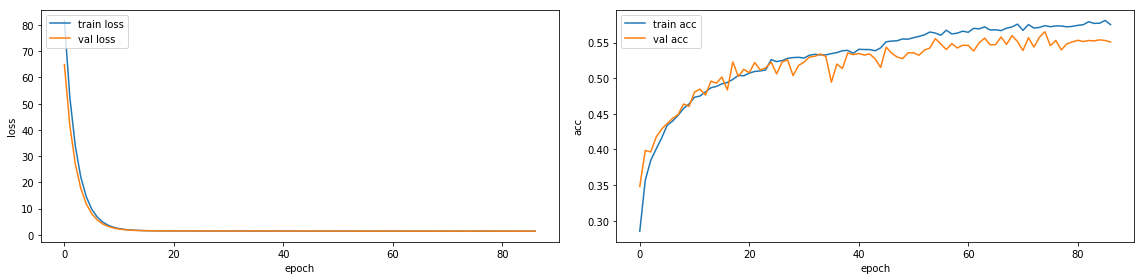

In [78]:
file_name = './Model/1st_place_featurewise_flip_seed_reg_valacc.hdf5'

# preprocess
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
# initializer
truncated_normal = TruncatedNormal(seed=0)

# model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal
                 , kernel_regularizer=regularizers.l2(0.01), name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer=truncated_normal
                , kernel_regularizer=regularizers.l2(0.01), name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer=truncated_normal, name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=file_name, monitor='val_acc',verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_acc', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]

# fit model
batch_size = 256
epochs = 200
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize metrics
helper.visualize_metrics(history)

# test model
print(model.evaluate_generator(test_datagen.flow(x_private, y_private_onehot, batch_size=batch_size), steps=batch_size))

## all preprocess

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 5s - loss: 1.8093 - acc: 0.2524 - val_loss: 1.8062 - val_acc: 0.2593
Epoch 59/100
112/112 [==============================] - 5s - loss: 1.8105 - acc: 0.2505 - val_loss: 1.8071 - val_acc: 0.2428
Epoch 60/100
112/112 [==============================] - 5s - loss: 1.8091 - acc: 0.2517 - val_loss: 1.8131 - val_acc: 0.2470
Epoch 61/100
112/112 [==============================] - 5s - loss: 1.8108 - acc: 0.2502 - val_loss: 1.8149 - val_acc: 0.2479
Epoch 62/100
112/112 [==============================] - 5s - loss: 1.8101 - acc: 0.2531 - val_loss: 1.8135 - val_acc: 0.2482
Epoch 63/100
112/112 [==============================] - 5s - loss: 1.8072 - acc: 0.2496 - val_loss: 1.8087 - val_acc: 0.2518
Epoch 64/100
112/112 [==============================] - 5s - loss: 1.8096 - acc: 0.2527 - val_loss: 1.8075 - val_acc: 0.2533
Epoch 65/100
112/112 [==============================] - 5s - loss: 1.8113 - acc: 0.2481 - val_loss: 1.8109 - val_acc: 0.2485
Epoch 66/100


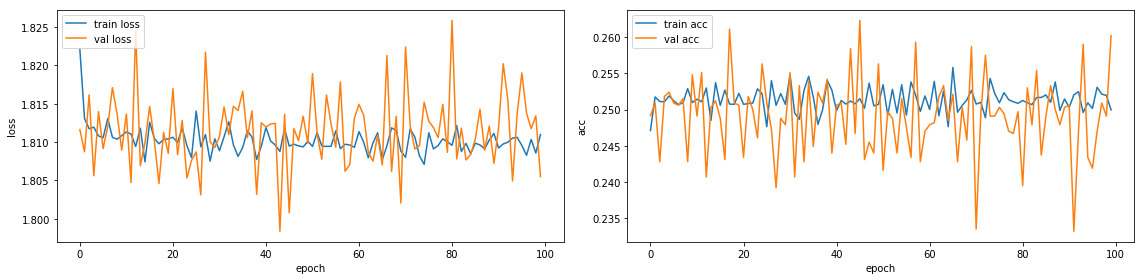

In [22]:
# preprocess
rescale_factor = 255
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2
                                   , horizontal_flip=True, rescale=1./rescale_factor)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                  , rescale=1./rescale_factor)
test_datagen.fit(x_train)


# # preprocess
# rescale_factor = 255
# train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
#                                    , horizontal_flip=True)
# train_datagen.fit(x_train)

# test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='./Model/1st_place_weights_allpreprocess.hdf5', verbose=1, save_best_only=True)
callbacks = [checkpointer, reduce_lr]

# fit model
batch_size = 256
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

## all preprocess - rescale

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 5s - loss: 1.2795 - acc: 0.5126 - val_loss: 1.1818 - val_acc: 0.5492
Epoch 51/100
112/112 [==============================] - 5s - loss: 1.2893 - acc: 0.5083 - val_loss: 1.1745 - val_acc: 0.5573
Epoch 52/100
112/112 [==============================] - 5s - loss: 1.2899 - acc: 0.5069 - val_loss: 1.1913 - val_acc: 0.5597
Epoch 53/100
112/112 [==============================] - 5s - loss: 1.2759 - acc: 0.5139 - val_loss: 1.1525 - val_acc: 0.5678
Epoch 54/100
112/112 [==============================] - 5s - loss: 1.2813 - acc: 0.5088 - val_loss: 1.1770 - val_acc: 0.5576
Epoch 55/100
112/112 [==============================] - 5s - loss: 1.2699 - acc: 0.5168 - val_loss: 1.1740 - val_acc: 0.5696
Epoch 56/100
112/112 [==============================] - 5s - loss: 1.2652 - acc: 0.5225 - val_loss: 1.1876 - val_acc: 0.5552
Epoch 57/100
112/112 [==============================] - 5s - loss: 1.2783 - acc: 0.5164 - val_loss: 1.1734 - val_acc: 0.5597
Epoch 58/100


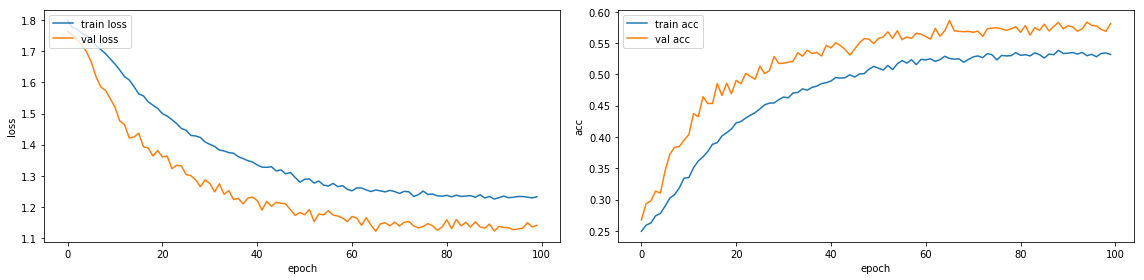

In [25]:
# preprocess
rescale_factor = 255
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)


# # preprocess
# rescale_factor = 255
# train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
#                                    , horizontal_flip=True)
# train_datagen.fit(x_train)

# test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
checkpointer = ModelCheckpoint(filepath='./Model/1st_place_weights_allpreprocess.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=5)
callbacks = [checkpointer, reduce_lr]

# fit model
batch_size = 256
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

Epoch 1/100
112/112 [==============================] - 5s - loss: 1.2286 - acc: 0.5328 - val_loss: 1.1330 - val_acc: 0.5778
Epoch 2/100
112/112 [==============================] - 5s - loss: 1.2295 - acc: 0.5342 - val_loss: 1.1364 - val_acc: 0.5849
Epoch 3/100
112/112 [==============================] - 5s - loss: 1.2337 - acc: 0.5326 - val_loss: 1.1262 - val_acc: 0.5798
Epoch 4/100
112/112 [==============================] - 5s - loss: 1.2332 - acc: 0.5289 - val_loss: 1.1307 - val_acc: 0.5795
Epoch 5/100
112/112 [==============================] - 5s - loss: 1.2232 - acc: 0.5358 - val_loss: 1.1491 - val_acc: 0.5687
Epoch 6/100
112/112 [==============================] - 5s - loss: 1.2340 - acc: 0.5322 - val_loss: 1.1408 - val_acc: 0.5729
Epoch 7/100
112/112 [==============================] - 5s - loss: 1.2367 - acc: 0.5303 - val_loss: 1.1347 - val_acc: 0.5765
Epoch 8/100
112/112 [==============================] - 5s - loss: 1.2287 - acc: 0.5317 - val_loss: 1.1330 - val_acc: 0.5738
Epoch 9/

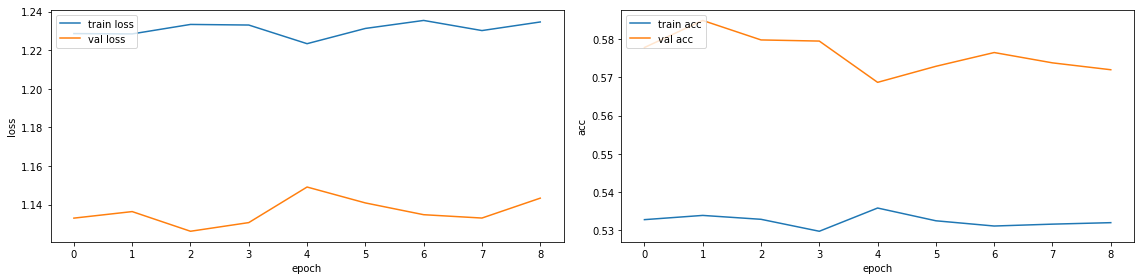

In [27]:
# continue training
callbacks = [checkpointer, reduce_lr, earlystopper]
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

Epoch 1/100
112/112 [==============================] - 5s - loss: 1.2323 - acc: 0.5318 - val_loss: 1.1313 - val_acc: 0.5778
Epoch 2/100
112/112 [==============================] - 5s - loss: 1.2334 - acc: 0.5304 - val_loss: 1.1050 - val_acc: 0.5789
Epoch 3/100
112/112 [==============================] - 5s - loss: 1.2291 - acc: 0.5358 - val_loss: 1.1428 - val_acc: 0.5696
Epoch 4/100
112/112 [==============================] - 5s - loss: 1.2300 - acc: 0.5357 - val_loss: 1.1308 - val_acc: 0.5771
Epoch 5/100
112/112 [==============================] - 5s - loss: 1.2330 - acc: 0.5346 - val_loss: 1.1296 - val_acc: 0.5744
Epoch 6/100
112/112 [==============================] - 5s - loss: 1.2350 - acc: 0.5312 - val_loss: 1.1403 - val_acc: 0.5708
Epoch 7/100
112/112 [==============================] - 5s - loss: 1.2297 - acc: 0.5342 - val_loss: 1.1316 - val_acc: 0.5753
Epoch 8/100
112/112 [==============================] - 5s - loss: 1.2317 - acc: 0.5322 - val_loss: 1.1349 - val_acc: 0.5711


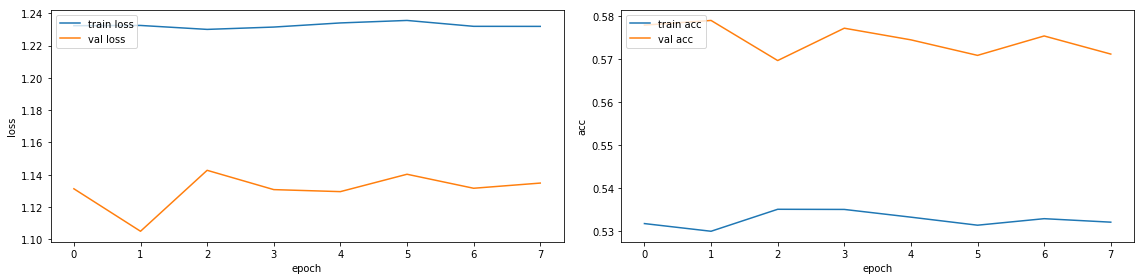

In [28]:
# reduce lower bound of lr and continue training
# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
callbacks = [checkpointer, reduce_lr, earlystopper]

# fit model
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

Epoch 1/100
112/112 [==============================] - 5s - loss: 1.2322 - acc: 0.5326 - val_loss: 1.1319 - val_acc: 0.5773
Epoch 2/100
112/112 [==============================] - 5s - loss: 1.2326 - acc: 0.5314 - val_loss: 1.1332 - val_acc: 0.5768
Epoch 3/100
112/112 [==============================] - 5s - loss: 1.2311 - acc: 0.5354 - val_loss: 1.1302 - val_acc: 0.5792
Epoch 4/100
112/112 [==============================] - 5s - loss: 1.2288 - acc: 0.5317 - val_loss: 1.1430 - val_acc: 0.5750
Epoch 5/100
112/112 [==============================] - 5s - loss: 1.2273 - acc: 0.5338 - val_loss: 1.1322 - val_acc: 0.5801
Epoch 6/100
112/112 [==============================] - 5s - loss: 1.2394 - acc: 0.5326 - val_loss: 1.1367 - val_acc: 0.5789
Epoch 7/100
112/112 [==============================] - 5s - loss: 1.2337 - acc: 0.5328 - val_loss: 1.1293 - val_acc: 0.5723
Epoch 8/100
112/112 [==============================] - 5s - loss: 1.2313 - acc: 0.5325 - val_loss: 1.1301 - val_acc: 0.5822
Epoch 9/

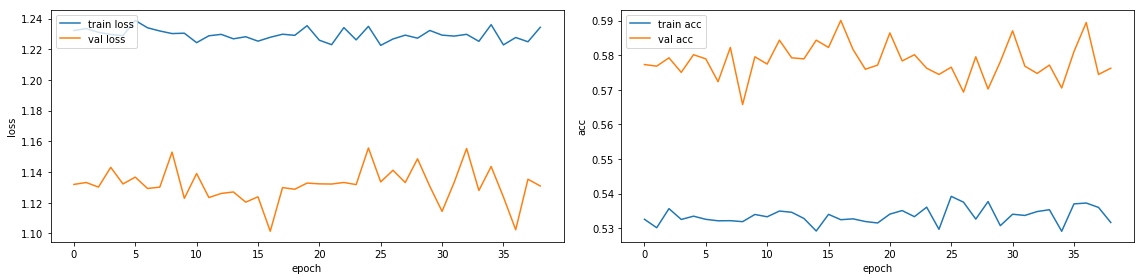

In [29]:
# increase patience factor of early stopper
# callbacks
earlystopper = EarlyStopping(monitor='val_loss', patience=21)
callbacks = [checkpointer, reduce_lr, earlystopper]

# fit model
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

In [30]:
k.get_value(sgd.lr)

9.9999997e-06

## all preprocess v2

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 5s - loss: 1.5765 - acc: 0.3799 - val_loss: 1.4262 - val_acc: 0.4472
Epoch 50/100
112/112 [==============================] - 5s - loss: 1.5554 - acc: 0.3926 - val_loss: 1.4288 - val_acc: 0.4496
Epoch 51/100
112/112 [==============================] - 5s - loss: 1.5547 - acc: 0.3947 - val_loss: 1.4176 - val_acc: 0.4574
Epoch 52/100
112/112 [==============================] - 5s - loss: 1.5355 - acc: 0.4010 - val_loss: 1.3954 - val_acc: 0.4706
Epoch 53/100
111/112 [============================>.] - ETA: 0s - loss: 1.5404 - acc: 0.4016Epoch 00052: val_loss did not improve

Epoch 00052: reducing learning rate to 0.0019999999552965165.
112/112 [==============================] - 5s - loss: 1.5410 - acc: 0.4012 - val_loss: 1.4056 - val_acc: 0.4685
Epoch 54/100
112/112 [==============================] - 5s - loss: 1.5155 - acc: 0.4109 - val_loss: 1.3850 - val_acc: 0.4745
Epoch 55/100
112/112 [==============================] - 5s - loss: 1.4995 - acc: 0.

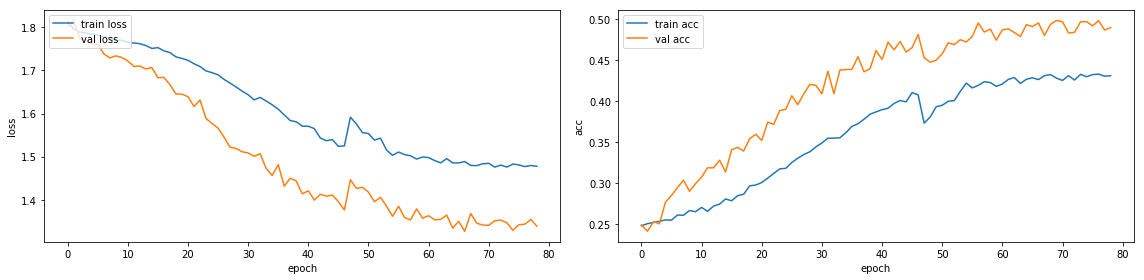

In [31]:
# preprocess
rescale_factor = 255
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2
                                   , horizontal_flip=True
                                   , rescale=1./rescale_factor*100)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                  , rescale=1./rescale_factor*100)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True, )
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath='./Model/1st_place_weights_allpreprocessv2.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, earlystopper]

# fit model
batch_size = 256
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

## all preprocess-rescale v2

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 5s - loss: 1.5121 - acc: 0.4145 - val_loss: 1.3528 - val_acc: 0.4892
Epoch 22/100
112/112 [==============================] - 5s - loss: 1.4962 - acc: 0.4234 - val_loss: 1.3478 - val_acc: 0.4904
Epoch 23/100
112/112 [==============================] - 5s - loss: 1.4865 - acc: 0.4239 - val_loss: 1.3423 - val_acc: 0.4934
Epoch 24/100
112/112 [==============================] - 5s - loss: 1.4790 - acc: 0.4302 - val_loss: 1.3320 - val_acc: 0.4955
Epoch 25/100
112/112 [==============================] - 5s - loss: 1.4689 - acc: 0.4349 - val_loss: 1.2930 - val_acc: 0.5180
Epoch 26/100
112/112 [==============================] - 5s - loss: 1.4587 - acc: 0.4382 - val_loss: 1.2939 - val_acc: 0.5060
Epoch 27/100
112/112 [==============================] - 5s - loss: 1.4496 - acc: 0.4433 - val_loss: 1.2807 - val_acc: 0.5132
Epoch 28/100
112/112 [==============================] - 5s - loss: 1.4316 - acc: 0.4508 - val_loss: 1.2830 - val_acc: 0.5096
Epoch 29/100


112/112 [==============================] - 11s - loss: 1.2173 - acc: 0.5403 - val_loss: 1.1159 - val_acc: 0.5831
Epoch 81/100
112/112 [==============================] - 7s - loss: 1.2299 - acc: 0.5342 - val_loss: 1.0972 - val_acc: 0.5897
Epoch 82/100
112/112 [==============================] - 5s - loss: 1.2185 - acc: 0.5396 - val_loss: 1.1021 - val_acc: 0.5846
Epoch 83/100
112/112 [==============================] - 5s - loss: 1.2351 - acc: 0.5278 - val_loss: 1.0988 - val_acc: 0.5876
Epoch 84/100
112/112 [==============================] - 5s - loss: 1.2162 - acc: 0.5399 - val_loss: 1.1232 - val_acc: 0.5792
Epoch 85/100
112/112 [==============================] - 5s - loss: 1.2193 - acc: 0.5370 - val_loss: 1.1029 - val_acc: 0.5888
Epoch 86/100
112/112 [==============================] - 5s - loss: 1.2266 - acc: 0.5326 - val_loss: 1.1066 - val_acc: 0.5822
Epoch 87/100
111/112 [============================>.] - ETA: 0s - loss: 1.2201 - acc: 0.5431Epoch 00086: val_loss did not improve

Epoch 

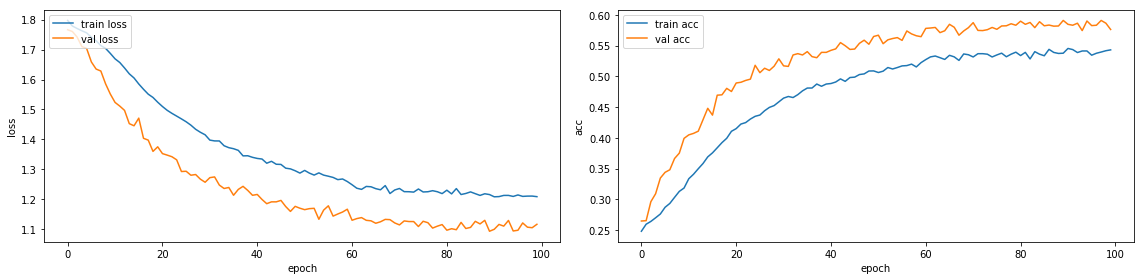

In [32]:
# preprocess
rescale_factor = 255
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)

# build model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer='TruncatedNormal', name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer='TruncatedNormal', name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer='TruncatedNormal', name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer='TruncatedNormal', name='Block4_Out'))

model.summary()

# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True )
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath='./Model/1st_place_weights_norescalev2.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, earlystopper]

# fit model
batch_size = 256
epochs = 100
print('Initial learning rate:', k.get_value(sgd.lr))
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)

# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

## norescale, weight_initialized std=sqrt(2/n)

In [35]:
model_name = './Model/1st_place_norescale_weightinitial_std.hdf5'

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
Block2_Pool (AveragePooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
Block3_Conv (Conv2D)         (None, 10, 10, 64)        51264     
__________

112/112 [==============================] - 5s - loss: 1.6749 - acc: 0.3309 - val_loss: 1.5625 - val_acc: 0.3824
Epoch 55/100
112/112 [==============================] - 5s - loss: 1.6574 - acc: 0.3402 - val_loss: 1.5357 - val_acc: 0.4010
Epoch 56/100
112/112 [==============================] - 5s - loss: 1.6639 - acc: 0.3363 - val_loss: 1.5408 - val_acc: 0.4058
Epoch 57/100
112/112 [==============================] - 5s - loss: 1.6530 - acc: 0.3419 - val_loss: 1.5190 - val_acc: 0.4295
Epoch 58/100
112/112 [==============================] - 5s - loss: 1.6418 - acc: 0.3495 - val_loss: 1.5039 - val_acc: 0.4328
Epoch 59/100
112/112 [==============================] - 5s - loss: 1.6423 - acc: 0.3463 - val_loss: 1.5035 - val_acc: 0.4223
Epoch 60/100
112/112 [==============================] - 5s - loss: 1.6331 - acc: 0.3540 - val_loss: 1.5075 - val_acc: 0.4217
Epoch 61/100
112/112 [==============================] - 5s - loss: 1.6261 - acc: 0.3577 - val_loss: 1.4924 - val_acc: 0.4217
Epoch 62/100


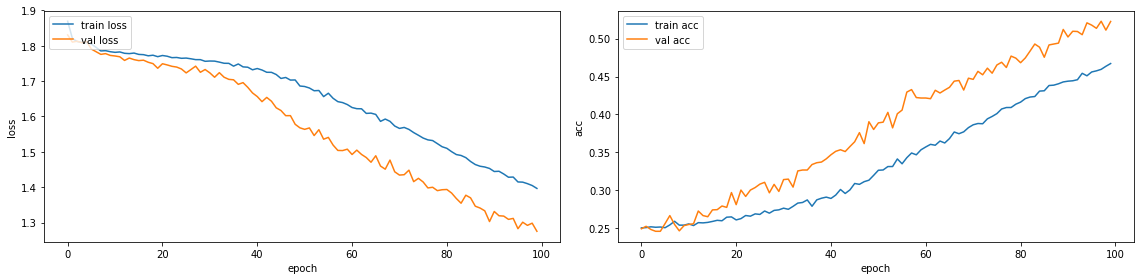

In [36]:
# preprocess
rescale_factor = 255
train_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True
                                   , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2
                                   , horizontal_flip=True)
train_datagen.fit(x_train)

test_datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_datagen.fit(x_train)


# build model
#initialier
truncated_normal = TruncatedNormal(stddev=np.sqrt(2/n_train), seed=0)

#model
model_name = '1st_place'
model = Sequential(name=model_name)
model.add(Cropping2D(cropping=3, input_shape=image_shape, name='Block1_Crop'))
model.add(Conv2D(32, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal, name='Block1_Conv'))
model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid', name='Block1_Pool'))

model.add(ZeroPadding2D(padding=1, name='Block2_Pad'))
model.add(Conv2D(32, (4,4), padding='valid', activation='relu', kernel_initializer=truncated_normal, name='Block2_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block2_Pool'))

model.add(Conv2D(64, (5,5), padding='same', activation='relu', kernel_initializer=truncated_normal, name='Block3_Conv'))
model.add(AveragePooling2D((2,2), strides=(2,2), padding='valid', name='Block3_Pool'))

model.add(Flatten(name='Block4_Flat'))
# TODO is this where dropout should be?
model.add(Dropout(0.2, name='Block4_Dropout'))
model.add(Dense(3072, activation='relu', kernel_initializer=truncated_normal, name='Block4_FC'))
# TODO svm activation function
model.add(Dense(n_classes, activation='softmax', kernel_initializer=truncated_normal, name='Block4_Out'))

model.summary()


# compile model
sgd = optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


# callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
checkpointer = ModelCheckpoint(filepath=model_name, verbose=1, save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=11)
callbacks = [checkpointer, reduce_lr, early_stopper]


# fit model
batch_size = 256
epochs = 100
print('Initial learning rate:', k.get_value(sgd.lr))
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)


# visualize loss
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train acc', 'val acc'], loc='upper left')

plt.tight_layout()

Epoch 1/100
112/112 [==============================] - 5s - loss: 1.3942 - acc: 0.4645 - val_loss: 1.2781 - val_acc: 0.5187
Epoch 2/100
112/112 [==============================] - 5s - loss: 1.3799 - acc: 0.4723 - val_loss: 1.2630 - val_acc: 0.5189
Epoch 3/100
112/112 [==============================] - 5s - loss: 1.3808 - acc: 0.4762 - val_loss: 1.2537 - val_acc: 0.5288
Epoch 4/100
112/112 [==============================] - 5s - loss: 1.3759 - acc: 0.4754 - val_loss: 1.2749 - val_acc: 0.5228
Epoch 5/100
112/112 [==============================] - 5s - loss: 1.3723 - acc: 0.4735 - val_loss: 1.2558 - val_acc: 0.5300
Epoch 6/100
112/112 [==============================] - 5s - loss: 1.3673 - acc: 0.4769 - val_loss: 1.2457 - val_acc: 0.5339
Epoch 7/100
112/112 [==============================] - 5s - loss: 1.3623 - acc: 0.4770 - val_loss: 1.2405 - val_acc: 0.5342
Epoch 8/100
112/112 [==============================] - 5s - loss: 1.3647 - acc: 0.4803 - val_loss: 1.2467 - val_acc: 0.5381
Epoch 9/

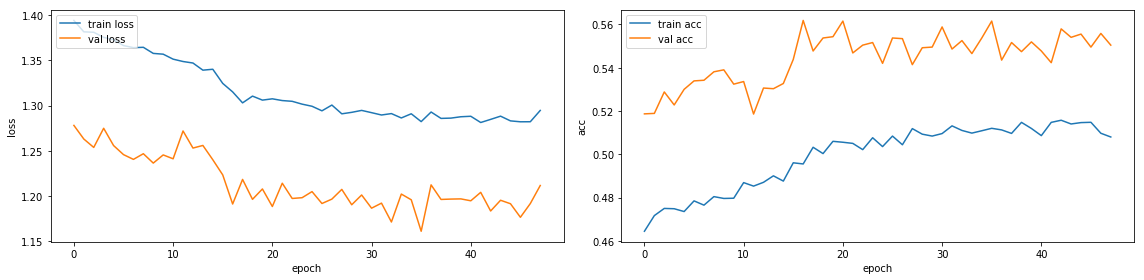

In [38]:
# continue training
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train, y_train_onehot, batch_size=batch_size)
                    , steps_per_epoch=n_train//batch_size
                    , epochs=epochs
                    , validation_data=test_datagen.flow(x_test, y_test_onehot, batch_size=batch_size)
                    , validation_steps=n_test//batch_size
                    , callbacks=callbacks)
visualize_metrics(history)

## batchnorm

In [65]:
file_name = './Model/1st_place_batchnorm.hdf5'

# build model
model = helper.build_model('1st_place', image_shape, n_classes)
model.summary()

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, file_name)

# visualize metrics
helper.visualize_metrics(history)

[autoreload of helper failed: Traceback (most recent call last):
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\IPython\extensions\autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\IPython\extensions\autoreload.py", line 369, in superreload
    module = reload(module)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 608, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
batch_normalization_69 (Batc (None, 42, 42, 32)        128       
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
batch_normalization_70 (Batc (None, 20, 20, 32)        128       
__________

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/200
112/112 [==============================] - 9s - loss: 9.1922 - acc: 0.1917 - val_loss: 10.1419 - val_acc: 0.1691
Epoch 2/200
112/112 [==============================] - 7s - loss: 8.0396 - acc: 0.1777 - val_loss: 8.0346 - val_acc: 0.1639
Epoch 3/200
112/112 [==============================] - 7s - loss: 6.6070 - acc: 0.1707 - val_loss: 6.5401 - val_acc: 0.1585
Epoch 4/200
112/112 [==============================] - 7s - loss: 6.4367 - acc: 0.1630 - val_loss: 6.6373 - val_acc: 0.1651
Epoch 5/200
112/112 [==============================] - 7s - loss: 6.4856 - acc: 0.1636 - val_loss: 6.7822 - val_acc: 0.1654
Epoch 6/200
112/112 [==============================] - 7s - loss: 6.5547 - acc: 0.1629 - val_loss: 6.6200 - val_acc: 0.1599
Epoch 7/200
112/112 [==============================] - 7s - loss: 6.4666 - acc: 0.1613 - val_loss: 6.6417 - val_acc: 0.1693
Epoch 8/200
112/112 [==============================] - 7s - loss: 6.6584 - acc: 0.1697 - val_loss: 6.8926

NameError: name 'plt' is not defined

## noscale, val_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 42, 42, 32)        0         
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20, 32)        0         
__________

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7999 - acc: 0.2473 - val_loss: 1.7698 - val_acc: 0.2545
Epoch 2/200
112/112 [==============================] - 5s - loss: 1.7796 - acc: 0.2562 - val_loss: 1.7524 - val_acc: 0.2734
Epoch 3/200
112/112 [==============================] - 5s - loss: 1.7751 - acc: 0.2592 - val_loss: 1.7379 - val_acc: 0.2890
Epoch 4/200
112/112 [==============================] - 5s - loss: 1.7635 - acc: 0.2696 - val_loss: 1.7154 - val_acc: 0.3328
Epoch 5/200
112/112 [==============================] - 5s - loss: 1.7577 - acc: 0.2700 - val_loss: 1.7068 - val_acc: 0.3082
Epoch 6/200
112/112 [==============================] - 5s - loss: 1.7473 - acc: 0.2795 - val_loss: 1.6938 - val_acc: 0.3286
Epoch 7/200
112/112 [==============================] - 5s - loss: 1.7369 - acc: 0.2888 - val_loss: 1.6643 - val_acc: 0.3538
Epoch 8/200
112/112 [==============================] - 5s - loss: 1.7218 - acc: 0.3002 - val_loss: 1.6437 

112/112 [==============================] - 5s - loss: 1.4559 - acc: 0.4386 - val_loss: 1.3168 - val_acc: 0.4967
Epoch 29/200
112/112 [==============================] - 5s - loss: 1.4409 - acc: 0.4465 - val_loss: 1.2903 - val_acc: 0.5089
Epoch 30/200
112/112 [==============================] - 5s - loss: 1.4326 - acc: 0.4496 - val_loss: 1.2689 - val_acc: 0.5219
Epoch 31/200
112/112 [==============================] - 5s - loss: 1.4153 - acc: 0.4554 - val_loss: 1.3423 - val_acc: 0.4958
Epoch 32/200
112/112 [==============================] - 5s - loss: 1.4175 - acc: 0.4566 - val_loss: 1.2518 - val_acc: 0.5249
Epoch 33/200
112/112 [==============================] - 5s - loss: 1.4044 - acc: 0.4640 - val_loss: 1.2740 - val_acc: 0.5180
Epoch 34/200
112/112 [==============================] - 5s - loss: 1.3918 - acc: 0.4659 - val_loss: 1.2816 - val_acc: 0.5165
Epoch 35/200
112/112 [==============================] - 5s - loss: 1.3895 - acc: 0.4675 - val_loss: 1.2486 - val_acc: 0.5225
Epoch 36/200


112/112 [==============================] - 5s - loss: 1.2707 - acc: 0.5168 - val_loss: 1.1623 - val_acc: 0.5636
Epoch 59/200
112/112 [==============================] - 5s - loss: 1.2768 - acc: 0.5145 - val_loss: 1.1610 - val_acc: 0.5582
Epoch 60/200
112/112 [==============================] - 5s - loss: 1.2661 - acc: 0.5189 - val_loss: 1.1611 - val_acc: 0.5684
Epoch 61/200
111/112 [============================>.] - ETA: 0s - loss: 1.2667 - acc: 0.5141Epoch 00060: val_loss did not improve

Epoch 00060: reducing learning rate to 0.004999999888241291.
112/112 [==============================] - 5s - loss: 1.2663 - acc: 0.5144 - val_loss: 1.1585 - val_acc: 0.5534
Epoch 62/200
112/112 [==============================] - 5s - loss: 1.2564 - acc: 0.5229 - val_loss: 1.1559 - val_acc: 0.5585
Epoch 63/200
112/112 [==============================] - 5s - loss: 1.2483 - acc: 0.5301 - val_loss: 1.1427 - val_acc: 0.5762
Epoch 64/200
112/112 [==============================] - 5s - loss: 1.2533 - acc: 0.5

112/112 [==============================] - 5s - loss: 1.2060 - acc: 0.5455 - val_loss: 1.1154 - val_acc: 0.5738
Epoch 90/200
112/112 [==============================] - 5s - loss: 1.2065 - acc: 0.5416 - val_loss: 1.1097 - val_acc: 0.5813
Epoch 91/200
111/112 [============================>.] - ETA: 0s - loss: 1.2105 - acc: 0.5395Epoch 00090: val_loss did not improve

Epoch 00090: reducing learning rate to 0.0006249999860301614.
112/112 [==============================] - 5s - loss: 1.2105 - acc: 0.5398 - val_loss: 1.0946 - val_acc: 0.5744
Epoch 92/200
112/112 [==============================] - 5s - loss: 1.2039 - acc: 0.5446 - val_loss: 1.1046 - val_acc: 0.5870


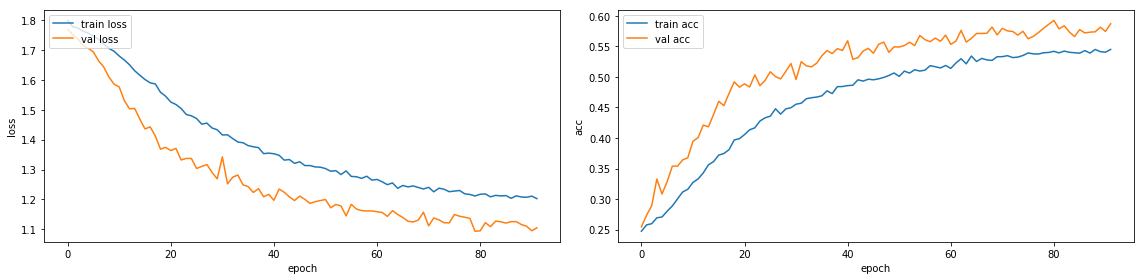

In [14]:
cp_name = './Model/1st_place_noscale_valloss.hdf5'

# build model
# initializer
truncated_normal = TruncatedNormal(seed=0)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal)
model.summary()

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                      , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2)

# visualize metrics
helper.visualize_metrics(history)

## noscale, val_loss, es_patience=21

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.01
Epoch 1/200
112/112 [==============================] - 5s - loss: 1.7980 - acc: 0.2497 - val_loss: 1.7657 - val_acc: 0.2617
Epoch 2/200
112/112 [==============================] - 5s - loss: 1.7818 - acc: 0.2568 - val_loss: 1.7607 - val_acc: 0.2596
Epoch 3/200
112/112 [==============================] - 5s - loss: 1.7754 - acc: 0.2588 - val_loss: 1.7454 - val_acc: 0.2917
Epoch 4/200
112/112 [==============================] - 5s - loss: 1.7660 - acc: 0.2656 - val_loss: 1.7338 - val_acc: 0.2878
Epoch 5/200
112/112 [==============================] - 5s - loss: 1.7617 - acc: 0.2726 - val_loss: 1.7233 - val_acc: 0.3241
Epoch 6/200
112/112 [==============================] - 5s - loss: 1.7525 - acc: 0.2764 - val_loss: 1.6984 - val_acc: 0.3274
Epoch 7/200
112/112 [==============================] - 5s - loss: 1.7448 - acc: 0.2833 - val_loss: 1.6753 - val_acc: 0.3412
Epoch 8/200
112/112 [==============================] - 5s - loss: 1.7284 - acc: 0.2941 - val_loss: 1.6479 

112/112 [==============================] - 5s - loss: 1.4641 - acc: 0.4352 - val_loss: 1.3217 - val_acc: 0.5015
Epoch 27/200
112/112 [==============================] - 5s - loss: 1.4594 - acc: 0.4376 - val_loss: 1.3355 - val_acc: 0.4844
Epoch 28/200
112/112 [==============================] - 5s - loss: 1.4482 - acc: 0.4418 - val_loss: 1.2966 - val_acc: 0.5126
Epoch 29/200
112/112 [==============================] - 5s - loss: 1.4403 - acc: 0.4444 - val_loss: 1.2862 - val_acc: 0.5153
Epoch 30/200
112/112 [==============================] - 5s - loss: 1.4281 - acc: 0.4552 - val_loss: 1.2855 - val_acc: 0.5131
Epoch 31/200
112/112 [==============================] - 5s - loss: 1.4292 - acc: 0.4533 - val_loss: 1.2706 - val_acc: 0.5264
Epoch 32/200
112/112 [==============================] - 5s - loss: 1.4025 - acc: 0.4602 - val_loss: 1.2817 - val_acc: 0.5156
Epoch 33/200
112/112 [==============================] - 5s - loss: 1.4019 - acc: 0.4641 - val_loss: 1.2466 - val_acc: 0.5240
Epoch 34/200


112/112 [==============================] - 5s - loss: 1.2674 - acc: 0.5166 - val_loss: 1.1794 - val_acc: 0.5561
Epoch 56/200
112/112 [==============================] - 5s - loss: 1.2936 - acc: 0.5094 - val_loss: 1.1740 - val_acc: 0.5498
Epoch 57/200
112/112 [==============================] - 5s - loss: 1.2825 - acc: 0.5159 - val_loss: 1.1546 - val_acc: 0.5618
Epoch 58/200
112/112 [==============================] - 5s - loss: 1.2710 - acc: 0.5175 - val_loss: 1.1719 - val_acc: 0.5633
Epoch 59/200
112/112 [==============================] - 5s - loss: 1.2772 - acc: 0.5155 - val_loss: 1.1589 - val_acc: 0.5723
Epoch 60/200
112/112 [==============================] - 5s - loss: 1.2770 - acc: 0.5178 - val_loss: 1.1804 - val_acc: 0.5579
Epoch 61/200
112/112 [==============================] - 5s - loss: 1.2672 - acc: 0.5199 - val_loss: 1.1692 - val_acc: 0.5579
Epoch 62/200
112/112 [==============================] - 5s - loss: 1.2691 - acc: 0.5156 - val_loss: 1.1577 - val_acc: 0.5630
Epoch 63/200


112/112 [==============================] - 5s - loss: 1.2455 - acc: 0.5280 - val_loss: 1.1346 - val_acc: 0.5804
Epoch 86/200
112/112 [==============================] - 5s - loss: 1.2359 - acc: 0.5345 - val_loss: 1.1411 - val_acc: 0.5810
Epoch 87/200
112/112 [==============================] - 5s - loss: 1.2332 - acc: 0.5310 - val_loss: 1.1416 - val_acc: 0.5681
Epoch 88/200
112/112 [==============================] - 5s - loss: 1.2361 - acc: 0.5350 - val_loss: 1.1283 - val_acc: 0.5861
Epoch 89/200
112/112 [==============================] - 5s - loss: 1.2318 - acc: 0.5352 - val_loss: 1.1517 - val_acc: 0.5735
Epoch 90/200
112/112 [==============================] - 5s - loss: 1.2354 - acc: 0.5314 - val_loss: 1.1191 - val_acc: 0.5810
Epoch 91/200
112/112 [==============================] - 5s - loss: 1.2398 - acc: 0.5294 - val_loss: 1.1497 - val_acc: 0.5741
Epoch 92/200
112/112 [==============================] - 5s - loss: 1.2292 - acc: 0.5338 - val_loss: 1.1232 - val_acc: 0.5735
Epoch 93/200


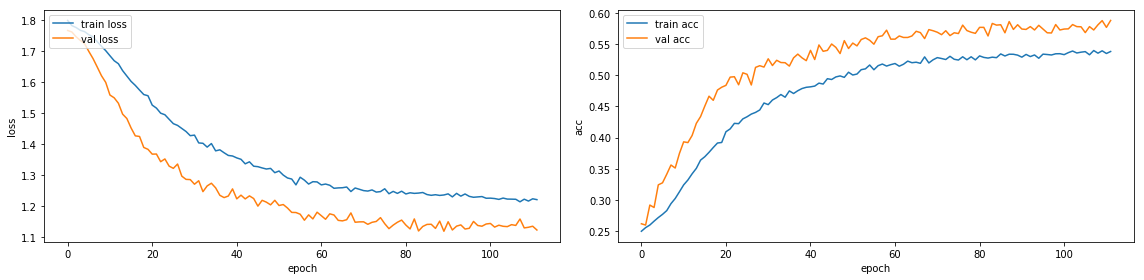

In [18]:
cp_name = './Model/1st_place_noscale_valloss_espatience21.hdf5'

# build model
# initializer
truncated_normal = TruncatedNormal(seed=0)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal)

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                       , es_patience=21
                      , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2)

# visualize metrics
helper.visualize_metrics(history)

## norescale, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 5s - loss: 1.8004 - acc: 0.2498 - val_loss: 1.7572 - val_acc: 0.2905
Epoch 2/1000
112/112 [==============================] - 5s - loss: 1.7745 - acc: 0.2590 - val_loss: 1.7070 - val_acc: 0.3175
Epoch 3/1000
112/112 [==============================] - 5s - loss: 1.7509 - acc: 0.2759 - val_loss: 1.6777 - val_acc: 0.3268
Epoch 4/1000
112/112 [==============================] - 5s - loss: 1.7620 - acc: 0.2740 - val_loss: 1.7302 - val_acc: 0.2959
Epoch 5/1000
112/112 [==============================] - 5s - loss: 1.7626 - acc: 0.2702 - val_loss: 1.7017 - val_acc: 0.3091
Epoch 6/1000
112/112 [==============================] - 5s - loss: 1.7481 - acc: 0.2759 - val_loss: 1.7051 - val_acc: 0.3154
Epoch 7/1000
112/112 [==============================] - 5s - loss: 1.7424 - acc: 0.2777 - val_loss: 1.6803 - val_acc: 0.3223
Epoch 8/1000
112/112 [==============================] - 5s - loss: 1.7369 - acc: 0.2875 - val_loss: 

112/112 [==============================] - 5s - loss: 1.3863 - acc: 0.4667 - val_loss: 1.2259 - val_acc: 0.5354
Epoch 27/1000
112/112 [==============================] - 5s - loss: 1.3846 - acc: 0.4653 - val_loss: 1.2280 - val_acc: 0.5294
Epoch 28/1000
112/112 [==============================] - 5s - loss: 1.3722 - acc: 0.4703 - val_loss: 1.2616 - val_acc: 0.5249
Epoch 29/1000
112/112 [==============================] - 5s - loss: 1.3605 - acc: 0.4795 - val_loss: 1.2396 - val_acc: 0.5297
Epoch 30/1000
112/112 [==============================] - 5s - loss: 1.3634 - acc: 0.4770 - val_loss: 1.2571 - val_acc: 0.5123
Epoch 31/1000
112/112 [==============================] - 5s - loss: 1.3477 - acc: 0.4785 - val_loss: 1.2230 - val_acc: 0.5318
Epoch 32/1000
112/112 [==============================] - 5s - loss: 1.3455 - acc: 0.4826 - val_loss: 1.1889 - val_acc: 0.5456
Epoch 33/1000
112/112 [==============================] - 5s - loss: 1.3278 - acc: 0.4877 - val_loss: 1.1987 - val_acc: 0.5402
Epoch 

112/112 [==============================] - 5s - loss: 1.2646 - acc: 0.5138 - val_loss: 1.1261 - val_acc: 0.5705
Epoch 56/1000
112/112 [==============================] - 5s - loss: 1.2622 - acc: 0.5152 - val_loss: 1.1526 - val_acc: 0.5546
Epoch 57/1000
112/112 [==============================] - 5s - loss: 1.2584 - acc: 0.5177 - val_loss: 1.1510 - val_acc: 0.5579
Epoch 58/1000
112/112 [==============================] - 5s - loss: 1.2583 - acc: 0.5185 - val_loss: 1.1413 - val_acc: 0.5735
Epoch 59/1000
112/112 [==============================] - 5s - loss: 1.2568 - acc: 0.5165 - val_loss: 1.1351 - val_acc: 0.5744
Epoch 60/1000
112/112 [==============================] - 5s - loss: 1.2564 - acc: 0.5211 - val_loss: 1.1448 - val_acc: 0.5681
Epoch 61/1000
112/112 [==============================] - 5s - loss: 1.2613 - acc: 0.5210 - val_loss: 1.1245 - val_acc: 0.5669
Epoch 62/1000
112/112 [==============================] - 5s - loss: 1.2453 - acc: 0.5261 - val_loss: 1.1403 - val_acc: 0.5645
Epoch 

112/112 [==============================] - 5s - loss: 1.1534 - acc: 0.5614 - val_loss: 1.0759 - val_acc: 0.5774
Epoch 86/1000
112/112 [==============================] - 5s - loss: 1.1531 - acc: 0.5585 - val_loss: 1.0919 - val_acc: 0.5828
Epoch 87/1000
112/112 [==============================] - 5s - loss: 1.1602 - acc: 0.5593 - val_loss: 1.0680 - val_acc: 0.5924
Epoch 88/1000
110/112 [============================>.] - ETA: 0s - loss: 1.1434 - acc: 0.5662Epoch 00087: val_loss did not improve

Epoch 00087: reducing learning rate to 0.012500000186264515.
112/112 [==============================] - 5s - loss: 1.1440 - acc: 0.5660 - val_loss: 1.0801 - val_acc: 0.5879
Epoch 89/1000
112/112 [==============================] - 5s - loss: 1.1467 - acc: 0.5614 - val_loss: 1.0656 - val_acc: 0.5981
Epoch 90/1000
112/112 [==============================] - 5s - loss: 1.1448 - acc: 0.5674 - val_loss: 1.0687 - val_acc: 0.5912
Epoch 91/1000
112/112 [==============================] - 5s - loss: 1.1427 - ac

112/112 [==============================] - 5s - loss: 1.1196 - acc: 0.5754 - val_loss: 1.0263 - val_acc: 0.6047
Epoch 117/1000
112/112 [==============================] - 5s - loss: 1.1177 - acc: 0.5783 - val_loss: 1.0542 - val_acc: 0.5972
Epoch 118/1000
112/112 [==============================] - 5s - loss: 1.1221 - acc: 0.5720 - val_loss: 1.0406 - val_acc: 0.6065
Epoch 119/1000
112/112 [==============================] - 5s - loss: 1.1129 - acc: 0.5779 - val_loss: 1.0485 - val_acc: 0.6059
Epoch 120/1000
112/112 [==============================] - 5s - loss: 1.1180 - acc: 0.5752 - val_loss: 1.0457 - val_acc: 0.6008
Epoch 121/1000
112/112 [==============================] - 5s - loss: 1.1188 - acc: 0.5751 - val_loss: 1.0429 - val_acc: 0.6086
Epoch 122/1000
111/112 [============================>.] - ETA: 0s - loss: 1.1146 - acc: 0.5769Epoch 00121: val_loss did not improve

Epoch 00121: reducing learning rate to 0.0015625000232830644.
112/112 [==============================] - 5s - loss: 1.11

112/112 [==============================] - 5s - loss: 1.1216 - acc: 0.5750 - val_loss: 1.0568 - val_acc: 0.5951
Epoch 149/1000
112/112 [==============================] - 5s - loss: 1.1102 - acc: 0.5781 - val_loss: 1.0482 - val_acc: 0.5936
Epoch 150/1000
112/112 [==============================] - 5s - loss: 1.1085 - acc: 0.5762 - val_loss: 1.0379 - val_acc: 0.6014
Epoch 151/1000
111/112 [============================>.] - ETA: 0s - loss: 1.1138 - acc: 0.5768Epoch 00150: val_loss did not improve

Epoch 00150: reducing learning rate to 9.765625145519152e-05.
112/112 [==============================] - 5s - loss: 1.1134 - acc: 0.5768 - val_loss: 1.0378 - val_acc: 0.6017
Epoch 152/1000
112/112 [==============================] - 5s - loss: 1.1239 - acc: 0.5724 - val_loss: 1.0409 - val_acc: 0.6014
Epoch 153/1000
112/112 [==============================] - 5s - loss: 1.0981 - acc: 0.5841 - val_loss: 1.0475 - val_acc: 0.6005
Epoch 154/1000
112/112 [==============================] - 5s - loss: 1.11

112/112 [==============================] - 5s - loss: 1.1044 - acc: 0.5825 - val_loss: 1.0234 - val_acc: 0.6095
Epoch 181/1000
111/112 [============================>.] - ETA: 0s - loss: 1.1236 - acc: 0.5772Epoch 00180: val_loss did not improve

Epoch 00180: reducing learning rate to 1.5258789289873675e-06.
112/112 [==============================] - 5s - loss: 1.1228 - acc: 0.5777 - val_loss: 1.0603 - val_acc: 0.5993
Epoch 182/1000
112/112 [==============================] - 5s - loss: 1.1027 - acc: 0.5812 - val_loss: 1.0446 - val_acc: 0.6044
Epoch 183/1000
112/112 [==============================] - 5s - loss: 1.1104 - acc: 0.5735 - val_loss: 1.0301 - val_acc: 0.6098
Epoch 184/1000
112/112 [==============================] - 5s - loss: 1.1177 - acc: 0.5751 - val_loss: 1.0449 - val_acc: 0.5996
Epoch 185/1000
112/112 [==============================] - 5s - loss: 1.1023 - acc: 0.5800 - val_loss: 1.0411 - val_acc: 0.6050
Epoch 186/1000
110/112 [============================>.] - ETA: 0s - loss

112/112 [==============================] - 5s - loss: 1.1051 - acc: 0.5818 - val_loss: 1.0388 - val_acc: 0.6062
Epoch 213/1000
112/112 [==============================] - 5s - loss: 1.1081 - acc: 0.5812 - val_loss: 1.0561 - val_acc: 0.5939
Epoch 214/1000
112/112 [==============================] - 5s - loss: 1.1159 - acc: 0.5774 - val_loss: 1.0270 - val_acc: 0.6059
Epoch 215/1000
112/112 [==============================] - 5s - loss: 1.1078 - acc: 0.5805 - val_loss: 1.0619 - val_acc: 0.5906
Epoch 216/1000
112/112 [==============================] - 5s - loss: 1.1149 - acc: 0.5790 - val_loss: 1.0379 - val_acc: 0.6086
Epoch 217/1000
112/112 [==============================] - 5s - loss: 1.1180 - acc: 0.5761 - val_loss: 1.0481 - val_acc: 0.6002
Epoch 218/1000
112/112 [==============================] - 5s - loss: 1.1058 - acc: 0.5814 - val_loss: 1.0364 - val_acc: 0.6032
Epoch 219/1000
112/112 [==============================] - 5s - loss: 1.1107 - acc: 0.5784 - val_loss: 1.0503 - val_acc: 0.5927

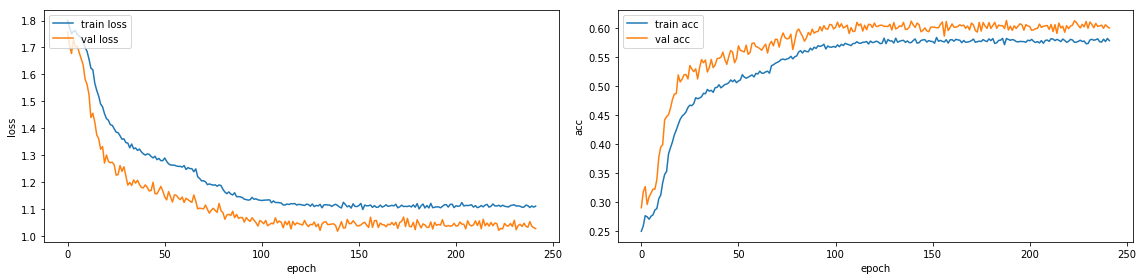

In [22]:
cp_name = './Model/1st_place_norescale_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer
truncated_normal = TruncatedNormal(seed=1)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal)

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000
                      , rotation_range=45., width_shift_range=0.2, height_shift_range=0.2)

# visualize metrics
helper.visualize_metrics(history)

## featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 1.8176 - acc: 0.2472 - val_loss: 1.7869 - val_acc: 0.2494
Epoch 2/1000
112/112 [==============================] - 3s - loss: 1.7095 - acc: 0.3103 - val_loss: 1.5772 - val_acc: 0.3923
Epoch 3/1000
112/112 [==============================] - 4s - loss: 1.5362 - acc: 0.4047 - val_loss: 1.4336 - val_acc: 0.4508
Epoch 4/1000
112/112 [==============================] - 3s - loss: 1.4471 - acc: 0.4403 - val_loss: 1.3717 - val_acc: 0.4745
Epoch 5/1000
112/112 [==============================] - 3s - loss: 1.3821 - acc: 0.4689 - val_loss: 1.2974 - val_acc: 0.5072
Epoch 6/1000
112/112 [==============================] - 4s - loss: 1.3244 - acc: 0.4925 - val_loss: 1.2799 - val_acc: 0.5129
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.2785 - acc: 0.5122 - val_loss: 1.2721 - val_acc: 0.5126
Epoch 8/1000
112/112 [==============================] - 3s - loss: 1.2389 - acc: 0.5272 - val_loss: 

112/112 [==============================] - 3s - loss: 0.3267 - acc: 0.8875 - val_loss: 1.4790 - val_acc: 0.5885
Epoch 29/1000
112/112 [==============================] - 3s - loss: 0.2908 - acc: 0.8979 - val_loss: 1.5019 - val_acc: 0.5966
Epoch 30/1000
110/112 [============================>.] - ETA: 0s - loss: 0.2872 - acc: 0.9020Epoch 00029: val_loss did not improve

Epoch 00029: reducing learning rate to 0.012500000186264515.
112/112 [==============================] - 3s - loss: 0.2877 - acc: 0.9017 - val_loss: 1.5433 - val_acc: 0.5903
Epoch 31/1000
112/112 [==============================] - 3s - loss: 0.2498 - acc: 0.9146 - val_loss: 1.5555 - val_acc: 0.5969
Epoch 32/1000
112/112 [==============================] - 4s - loss: 0.2215 - acc: 0.9267 - val_loss: 1.5625 - val_acc: 0.6030
Epoch 33/1000
112/112 [==============================] - 3s - loss: 0.2068 - acc: 0.9306 - val_loss: 1.5378 - val_acc: 0.6077
Epoch 34/1000
112/112 [==============================] - 3s - loss: 0.1971 - ac

111/112 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9595Epoch 00059: val_loss did not improve

Epoch 00059: reducing learning rate to 0.00019531250291038305.
112/112 [==============================] - 3s - loss: 0.1263 - acc: 0.9595 - val_loss: 1.7258 - val_acc: 0.6068
Epoch 61/1000
112/112 [==============================] - 3s - loss: 0.1185 - acc: 0.9620 - val_loss: 1.7224 - val_acc: 0.6104
Epoch 62/1000
112/112 [==============================] - 3s - loss: 0.1204 - acc: 0.9611 - val_loss: 1.7755 - val_acc: 0.6029
Epoch 63/1000
112/112 [==============================] - 3s - loss: 0.1210 - acc: 0.9614 - val_loss: 1.7516 - val_acc: 0.5972
Epoch 64/1000
112/112 [==============================] - 3s - loss: 0.1212 - acc: 0.9612 - val_loss: 1.7847 - val_acc: 0.5981
Epoch 65/1000
111/112 [============================>.] - ETA: 0s - loss: 0.1264 - acc: 0.9603Epoch 00064: val_loss did not improve

Epoch 00064: reducing learning rate to 9.765625145519152e-05.
112/112 [

112/112 [==============================] - 3s - loss: 0.1194 - acc: 0.9619 - val_loss: 1.7140 - val_acc: 0.6074
Epoch 92/1000
112/112 [==============================] - 3s - loss: 0.1227 - acc: 0.9591 - val_loss: 1.7764 - val_acc: 0.5987
Epoch 93/1000
112/112 [==============================] - 3s - loss: 0.1218 - acc: 0.9605 - val_loss: 1.6913 - val_acc: 0.6104
Epoch 94/1000
112/112 [==============================] - 3s - loss: 0.1215 - acc: 0.9609 - val_loss: 1.7389 - val_acc: 0.6008
Epoch 95/1000
110/112 [============================>.] - ETA: 0s - loss: 0.1205 - acc: 0.9611Epoch 00094: val_loss did not improve

Epoch 00094: reducing learning rate to 1.5258789289873675e-06.
112/112 [==============================] - 3s - loss: 0.1206 - acc: 0.9610 - val_loss: 1.7320 - val_acc: 0.6038
Epoch 96/1000
112/112 [==============================] - 3s - loss: 0.1219 - acc: 0.9604 - val_loss: 1.7881 - val_acc: 0.6002
Epoch 97/1000
112/112 [==============================] - 3s - loss: 0.1229 - 

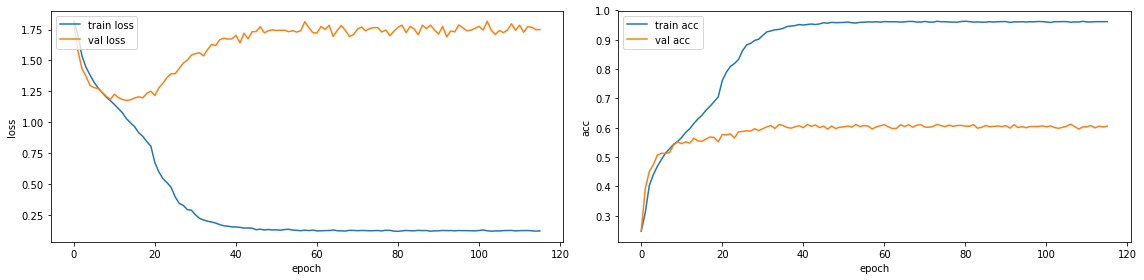

In [23]:
cp_name = './Model/1st_place_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer
truncated_normal = TruncatedNormal(seed=1)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal)

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)

# visualize metrics
helper.visualize_metrics(history)

## kernel_reg, featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 27.3108 - acc: 0.2440 - val_loss: 2.4514 - val_acc: 0.2489
Epoch 2/1000
112/112 [==============================] - 4s - loss: 1.9260 - acc: 0.2518 - val_loss: 1.8131 - val_acc: 0.2494
Epoch 3/1000
112/112 [==============================] - 4s - loss: 1.8112 - acc: 0.2518 - val_loss: 1.8112 - val_acc: 0.2512
Epoch 4/1000
112/112 [==============================] - 4s - loss: 1.8109 - acc: 0.2506 - val_loss: 1.8052 - val_acc: 0.2548
Epoch 5/1000
112/112 [==============================] - 4s - loss: 1.8101 - acc: 0.2514 - val_loss: 1.8132 - val_acc: 0.2458
Epoch 6/1000
112/112 [==============================] - 4s - loss: 1.8116 - acc: 0.2523 - val_loss: 1.8105 - val_acc: 0.2452
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.8125 - acc: 0.2500 - val_loss: 1.8158 - val_acc: 0.2434
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.8107 - acc: 0.2510 - val_loss:

110/112 [============================>.] - ETA: 0s - loss: 1.8088 - acc: 0.2512Epoch 00030: val_loss did not improve

Epoch 00030: reducing learning rate to 0.0062500000931322575.
112/112 [==============================] - 4s - loss: 1.8089 - acc: 0.2517 - val_loss: 1.8112 - val_acc: 0.2548
Epoch 32/1000
112/112 [==============================] - 4s - loss: 1.8120 - acc: 0.2514 - val_loss: 1.8156 - val_acc: 0.2395
Epoch 33/1000
112/112 [==============================] - 4s - loss: 1.8067 - acc: 0.2534 - val_loss: 1.8129 - val_acc: 0.2479
Epoch 34/1000
112/112 [==============================] - 4s - loss: 1.8134 - acc: 0.2485 - val_loss: 1.8128 - val_acc: 0.2464
Epoch 35/1000
112/112 [==============================] - 4s - loss: 1.8051 - acc: 0.2546 - val_loss: 1.8087 - val_acc: 0.2479
Epoch 36/1000
111/112 [============================>.] - ETA: 0s - loss: 1.8104 - acc: 0.2503Epoch 00035: val_loss did not improve

Epoch 00035: reducing learning rate to 0.0031250000465661287.
112/112 [=

112/112 [==============================] - 4s - loss: 1.8104 - acc: 0.2503 - val_loss: 1.8118 - val_acc: 0.2479
Epoch 63/1000
112/112 [==============================] - 4s - loss: 1.8101 - acc: 0.2503 - val_loss: 1.8149 - val_acc: 0.2491
Epoch 64/1000
112/112 [==============================] - 4s - loss: 1.8094 - acc: 0.2519 - val_loss: 1.8140 - val_acc: 0.2482
Epoch 65/1000
112/112 [==============================] - 4s - loss: 1.8080 - acc: 0.2527 - val_loss: 1.8104 - val_acc: 0.2461
Epoch 66/1000
110/112 [============================>.] - ETA: 0s - loss: 1.8119 - acc: 0.2503Epoch 00065: val_loss did not improve

Epoch 00065: reducing learning rate to 4.882812572759576e-05.
112/112 [==============================] - 4s - loss: 1.8115 - acc: 0.2505 - val_loss: 1.8083 - val_acc: 0.2548
Epoch 67/1000
112/112 [==============================] - 4s - loss: 1.8111 - acc: 0.2515 - val_loss: 1.8094 - val_acc: 0.2422
Epoch 68/1000
112/112 [==============================] - 4s - loss: 1.8084 - a

112/112 [==============================] - 4s - loss: 1.8100 - acc: 0.2498 - val_loss: 1.8148 - val_acc: 0.2488
Epoch 95/1000
112/112 [==============================] - 4s - loss: 1.8101 - acc: 0.2542 - val_loss: 1.8083 - val_acc: 0.2446
Epoch 96/1000
110/112 [============================>.] - ETA: 0s - loss: 1.8086 - acc: 0.2519Epoch 00095: val_loss did not improve

Epoch 00095: reducing learning rate to 1.5258789289873675e-06.
112/112 [==============================] - 4s - loss: 1.8089 - acc: 0.2515 - val_loss: 1.8141 - val_acc: 0.2509
Epoch 97/1000
112/112 [==============================] - 4s - loss: 1.8087 - acc: 0.2511 - val_loss: 1.8098 - val_acc: 0.2506
Epoch 98/1000
112/112 [==============================] - 4s - loss: 1.8088 - acc: 0.2519 - val_loss: 1.8105 - val_acc: 0.2557
Epoch 99/1000
112/112 [==============================] - 4s - loss: 1.8102 - acc: 0.2508 - val_loss: 1.8129 - val_acc: 0.2479
Epoch 100/1000
112/112 [==============================] - 4s - loss: 1.8102 -

112/112 [==============================] - 4s - loss: 1.8080 - acc: 0.2526 - val_loss: 1.8107 - val_acc: 0.2464
Epoch 127/1000
112/112 [==============================] - 4s - loss: 1.8092 - acc: 0.2501 - val_loss: 1.8041 - val_acc: 0.2638
Epoch 128/1000
112/112 [==============================] - 4s - loss: 1.8101 - acc: 0.2518 - val_loss: 1.8130 - val_acc: 0.2470
Epoch 129/1000
112/112 [==============================] - 4s - loss: 1.8109 - acc: 0.2514 - val_loss: 1.8108 - val_acc: 0.2488
Epoch 130/1000
112/112 [==============================] - 4s - loss: 1.8092 - acc: 0.2501 - val_loss: 1.8115 - val_acc: 0.2464
Epoch 131/1000
112/112 [==============================] - 4s - loss: 1.8084 - acc: 0.2526 - val_loss: 1.8087 - val_acc: 0.2449
Epoch 132/1000
112/112 [==============================] - 4s - loss: 1.8100 - acc: 0.2520 - val_loss: 1.8030 - val_acc: 0.2437
Epoch 133/1000
112/112 [==============================] - 4s - loss: 1.8087 - acc: 0.2513 - val_loss: 1.8149 - val_acc: 0.2479

112/112 [==============================] - 4s - loss: 1.8097 - acc: 0.2486 - val_loss: 1.8164 - val_acc: 0.2470
Epoch 160/1000
112/112 [==============================] - 4s - loss: 1.8077 - acc: 0.2536 - val_loss: 1.8111 - val_acc: 0.2539
Epoch 161/1000
112/112 [==============================] - 4s - loss: 1.8116 - acc: 0.2505 - val_loss: 1.8198 - val_acc: 0.2413
Epoch 162/1000
112/112 [==============================] - 4s - loss: 1.8075 - acc: 0.2503 - val_loss: 1.8066 - val_acc: 0.2524
Epoch 163/1000
112/112 [==============================] - 4s - loss: 1.8125 - acc: 0.2502 - val_loss: 1.8096 - val_acc: 0.2503
Epoch 164/1000
112/112 [==============================] - 4s - loss: 1.8085 - acc: 0.2494 - val_loss: 1.8107 - val_acc: 0.2492
Epoch 165/1000
112/112 [==============================] - 4s - loss: 1.8115 - acc: 0.2517 - val_loss: 1.8094 - val_acc: 0.2566
Epoch 166/1000
112/112 [==============================] - 4s - loss: 1.8054 - acc: 0.2551 - val_loss: 1.8112 - val_acc: 0.2482

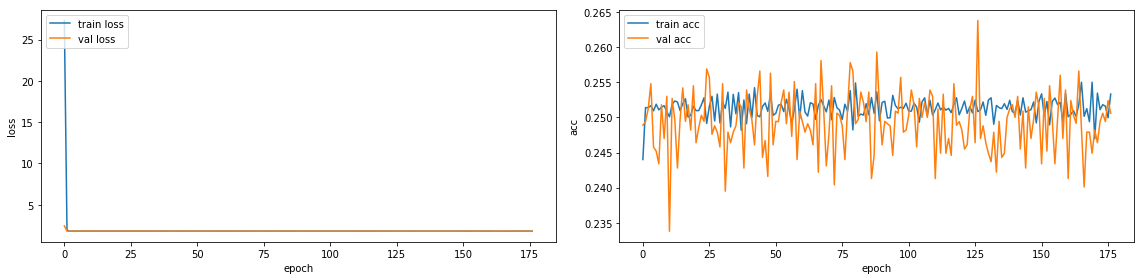

In [24]:
cp_name = './Model/1st_place_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.01)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

## kernel_reg0.001, featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 9.7840 - acc: 0.2928 - val_loss: 7.9548 - val_acc: 0.3817
Epoch 2/1000
112/112 [==============================] - 4s - loss: 6.6953 - acc: 0.3973 - val_loss: 5.5568 - val_acc: 0.4247
Epoch 3/1000
112/112 [==============================] - 4s - loss: 4.7592 - acc: 0.4354 - val_loss: 4.0150 - val_acc: 0.4646
Epoch 4/1000
112/112 [==============================] - 4s - loss: 3.5229 - acc: 0.4625 - val_loss: 3.0640 - val_acc: 0.4721
Epoch 5/1000
112/112 [==============================] - 4s - loss: 2.7403 - acc: 0.4883 - val_loss: 2.4056 - val_acc: 0.5045
Epoch 6/1000
112/112 [==============================] - 4s - loss: 2.2252 - acc: 0.5123 - val_loss: 2.0476 - val_acc: 0.5183
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.9055 - acc: 0.5313 - val_loss: 1.8153 - val_acc: 0.5141
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.7028 - acc: 0.5385 - val_loss: 

112/112 [==============================] - 4s - loss: 1.2936 - acc: 0.6299 - val_loss: 1.4213 - val_acc: 0.5771
Epoch 26/1000
112/112 [==============================] - 4s - loss: 1.2492 - acc: 0.6465 - val_loss: 1.3819 - val_acc: 0.5984
Epoch 27/1000
112/112 [==============================] - 4s - loss: 1.2250 - acc: 0.6543 - val_loss: 1.4006 - val_acc: 0.5897
Epoch 28/1000
112/112 [==============================] - 4s - loss: 1.2241 - acc: 0.6587 - val_loss: 1.4167 - val_acc: 0.6059
Epoch 29/1000
110/112 [============================>.] - ETA: 0s - loss: 1.2248 - acc: 0.6581Epoch 00028: val_loss did not improve

Epoch 00028: reducing learning rate to 0.02500000037252903.
112/112 [==============================] - 4s - loss: 1.2241 - acc: 0.6585 - val_loss: 1.4115 - val_acc: 0.5981
Epoch 30/1000
112/112 [==============================] - 4s - loss: 1.1543 - acc: 0.6922 - val_loss: 1.4079 - val_acc: 0.6020
Epoch 31/1000
112/112 [==============================] - 4s - loss: 1.1194 - acc

112/112 [==============================] - 4s - loss: 0.6715 - acc: 0.9142 - val_loss: 1.6465 - val_acc: 0.6248
Epoch 58/1000
112/112 [==============================] - 4s - loss: 0.6688 - acc: 0.9158 - val_loss: 1.6181 - val_acc: 0.6273
Epoch 59/1000
111/112 [============================>.] - ETA: 0s - loss: 0.6636 - acc: 0.9188Epoch 00058: val_loss did not improve

Epoch 00058: reducing learning rate to 0.0003906250058207661.
112/112 [==============================] - 4s - loss: 0.6638 - acc: 0.9188 - val_loss: 1.6400 - val_acc: 0.6203
Epoch 60/1000
112/112 [==============================] - 4s - loss: 0.6655 - acc: 0.9174 - val_loss: 1.6136 - val_acc: 0.6339
Epoch 61/1000
112/112 [==============================] - 4s - loss: 0.6607 - acc: 0.9208 - val_loss: 1.6313 - val_acc: 0.6295
Epoch 62/1000
112/112 [==============================] - 4s - loss: 0.6568 - acc: 0.9199 - val_loss: 1.6032 - val_acc: 0.6315
Epoch 63/1000
112/112 [==============================] - 4s - loss: 0.6621 - a

111/112 [============================>.] - ETA: 0s - loss: 0.6422 - acc: 0.9263Epoch 00088: val_loss did not improve

Epoch 00088: reducing learning rate to 6.10351571594947e-06.
112/112 [==============================] - 4s - loss: 0.6422 - acc: 0.9263 - val_loss: 1.6451 - val_acc: 0.6318
Epoch 90/1000
112/112 [==============================] - 4s - loss: 0.6417 - acc: 0.9272 - val_loss: 1.6467 - val_acc: 0.6309
Epoch 91/1000
112/112 [==============================] - 4s - loss: 0.6453 - acc: 0.9236 - val_loss: 1.6197 - val_acc: 0.6375
Epoch 92/1000
112/112 [==============================] - 4s - loss: 0.6391 - acc: 0.9295 - val_loss: 1.6314 - val_acc: 0.6291
Epoch 93/1000
112/112 [==============================] - 4s - loss: 0.6446 - acc: 0.9259 - val_loss: 1.6316 - val_acc: 0.6327
Epoch 94/1000
111/112 [============================>.] - ETA: 0s - loss: 0.6439 - acc: 0.9257Epoch 00093: val_loss did not improve

Epoch 00093: reducing learning rate to 3.051757857974735e-06.
112/112 [==

112/112 [==============================] - 4s - loss: 0.6417 - acc: 0.9265 - val_loss: 1.6482 - val_acc: 0.6291


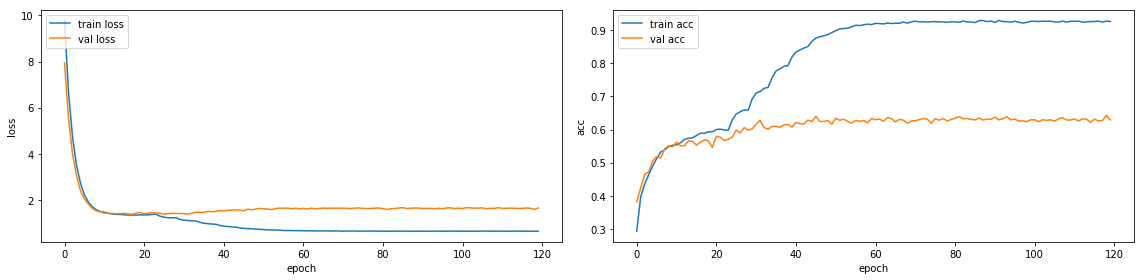

In [25]:
cp_name = './Model/1st_place_kernelreg0.001_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.001)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(x_train, y_train, x_test, y_test, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 9.7324 - acc: 0.3221 - val_loss: 7.9097 - val_acc: 0.4057
Epoch 2/1000
112/112 [==============================] - 4s - loss: 6.6518 - acc: 0.4128 - val_loss: 5.5071 - val_acc: 0.4358
Epoch 3/1000
112/112 [==============================] - 4s - loss: 4.7165 - acc: 0.4601 - val_loss: 3.9576 - val_acc: 0.5003
Epoch 4/1000
112/112 [==============================] - 4s - loss: 3.4690 - acc: 0.4918 - val_loss: 3.0040 - val_acc: 0.5090
Epoch 5/1000
112/112 [==============================] - 4s - loss: 2.6958 - acc: 0.5110 - val_loss: 2.4195 - val_acc: 0.5114
Epoch 6/1000
112/112 [==============================] - 4s - loss: 2.2202 - acc: 0.5169 - val_loss: 2.0170 - val_acc: 0.5351
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.8878 - acc: 0.5410 - val_loss: 1.7925 - val_acc: 0.5252
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.6881 - acc: 0.5455 - val_loss: 

112/112 [==============================] - 4s - loss: 1.2129 - acc: 0.6561 - val_loss: 1.3618 - val_acc: 0.5942
Epoch 26/1000
112/112 [==============================] - 4s - loss: 1.2096 - acc: 0.6569 - val_loss: 1.3620 - val_acc: 0.6002
Epoch 27/1000
112/112 [==============================] - 4s - loss: 1.2125 - acc: 0.6613 - val_loss: 1.3838 - val_acc: 0.5979
Epoch 28/1000
112/112 [==============================] - 4s - loss: 1.2118 - acc: 0.6647 - val_loss: 1.3930 - val_acc: 0.6008
Epoch 29/1000
112/112 [==============================] - 4s - loss: 1.2013 - acc: 0.6727 - val_loss: 1.4212 - val_acc: 0.5981
Epoch 30/1000
111/112 [============================>.] - ETA: 0s - loss: 1.2111 - acc: 0.6793Epoch 00029: val_loss did not improve

Epoch 00029: reducing learning rate to 0.02500000037252903.
112/112 [==============================] - 4s - loss: 1.2111 - acc: 0.6794 - val_loss: 1.4116 - val_acc: 0.6005
Epoch 31/1000
112/112 [==============================] - 4s - loss: 1.1299 - acc

112/112 [==============================] - 4s - loss: 0.6637 - acc: 0.9243 - val_loss: 1.7196 - val_acc: 0.6206
Epoch 58/1000
112/112 [==============================] - 4s - loss: 0.6562 - acc: 0.9281 - val_loss: 1.6611 - val_acc: 0.6282
Epoch 59/1000
112/112 [==============================] - 4s - loss: 0.6579 - acc: 0.9291 - val_loss: 1.6659 - val_acc: 0.6291
Epoch 60/1000
111/112 [============================>.] - ETA: 0s - loss: 0.6496 - acc: 0.9306Epoch 00059: val_loss did not improve

Epoch 00059: reducing learning rate to 0.0003906250058207661.
112/112 [==============================] - 4s - loss: 0.6493 - acc: 0.9308 - val_loss: 1.6538 - val_acc: 0.6312
Epoch 61/1000
112/112 [==============================] - 4s - loss: 0.6504 - acc: 0.9315 - val_loss: 1.6623 - val_acc: 0.6273
Epoch 62/1000
112/112 [==============================] - 4s - loss: 0.6424 - acc: 0.9333 - val_loss: 1.6803 - val_acc: 0.6194
Epoch 63/1000
112/112 [==============================] - 4s - loss: 0.6406 - a

112/112 [==============================] - 4s - loss: 0.6303 - acc: 0.9394 - val_loss: 1.6641 - val_acc: 0.6387
Epoch 89/1000
112/112 [==============================] - 4s - loss: 0.6341 - acc: 0.9370 - val_loss: 1.6824 - val_acc: 0.6270
Epoch 90/1000
110/112 [============================>.] - ETA: 0s - loss: 0.6321 - acc: 0.9375Epoch 00089: val_loss did not improve

Epoch 00089: reducing learning rate to 6.10351571594947e-06.
112/112 [==============================] - 4s - loss: 0.6321 - acc: 0.9375 - val_loss: 1.6747 - val_acc: 0.6297
Epoch 91/1000
112/112 [==============================] - 4s - loss: 0.6330 - acc: 0.9393 - val_loss: 1.6964 - val_acc: 0.6194
Epoch 92/1000
112/112 [==============================] - 4s - loss: 0.6324 - acc: 0.9374 - val_loss: 1.6761 - val_acc: 0.6264
Epoch 93/1000
112/112 [==============================] - 4s - loss: 0.6332 - acc: 0.9377 - val_loss: 1.6437 - val_acc: 0.6345
Epoch 94/1000
112/112 [==============================] - 4s - loss: 0.6304 - ac

112/112 [==============================] - 4s - loss: 0.6363 - acc: 0.9350 - val_loss: 1.7015 - val_acc: 0.6206
Epoch 121/1000
112/112 [==============================] - 4s - loss: 0.6299 - acc: 0.9397 - val_loss: 1.6841 - val_acc: 0.6270
Epoch 122/1000
112/112 [==============================] - 4s - loss: 0.6319 - acc: 0.9377 - val_loss: 1.6774 - val_acc: 0.6324
Epoch 123/1000
112/112 [==============================] - 4s - loss: 0.6368 - acc: 0.9351 - val_loss: 1.6477 - val_acc: 0.6351
Epoch 124/1000
112/112 [==============================] - 4s - loss: 0.6343 - acc: 0.9357 - val_loss: 1.6650 - val_acc: 0.6306
Epoch 125/1000
112/112 [==============================] - 4s - loss: 0.6347 - acc: 0.9373 - val_loss: 1.6622 - val_acc: 0.6270
Epoch 126/1000
112/112 [==============================] - 4s - loss: 0.6300 - acc: 0.9403 - val_loss: 1.6737 - val_acc: 0.6283
private test metrics [1.6186933990954442, 0.63663516625846861]


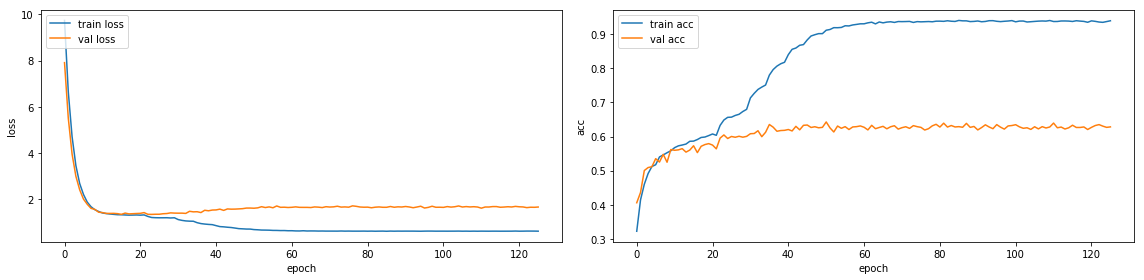

In [37]:
cp_name = './Model/1st_place_kernelreg0.001_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.001)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(data_formatted, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 9.7176 - acc: 0.3293 - val_loss: 7.8892 - val_acc: 0.4113
Epoch 2/1000
112/112 [==============================] - 4s - loss: 6.6199 - acc: 0.4334 - val_loss: 5.4610 - val_acc: 0.4754
Epoch 3/1000
112/112 [==============================] - 4s - loss: 4.6852 - acc: 0.4736 - val_loss: 3.9681 - val_acc: 0.4901
Epoch 4/1000
112/112 [==============================] - 4s - loss: 3.4485 - acc: 0.5046 - val_loss: 2.9725 - val_acc: 0.5183
Epoch 5/1000
112/112 [==============================] - 4s - loss: 2.6701 - acc: 0.5257 - val_loss: 2.3873 - val_acc: 0.5348
Epoch 6/1000
112/112 [==============================] - 4s - loss: 2.2563 - acc: 0.5110 - val_loss: 2.0391 - val_acc: 0.5273
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.8898 - acc: 0.5426 - val_loss: 1.7824 - val_acc: 0.5366
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.6762 - acc: 0.5543 - val_loss: 

112/112 [==============================] - 4s - loss: 1.2137 - acc: 0.6460 - val_loss: 1.3407 - val_acc: 0.5852
Epoch 26/1000
112/112 [==============================] - 4s - loss: 1.1971 - acc: 0.6533 - val_loss: 1.3409 - val_acc: 0.5924
Epoch 27/1000
112/112 [==============================] - 4s - loss: 1.1956 - acc: 0.6545 - val_loss: 1.3286 - val_acc: 0.6020
Epoch 28/1000
112/112 [==============================] - 4s - loss: 1.1917 - acc: 0.6583 - val_loss: 1.3371 - val_acc: 0.5909
Epoch 29/1000
112/112 [==============================] - 4s - loss: 1.1858 - acc: 0.6668 - val_loss: 1.3756 - val_acc: 0.5996
Epoch 30/1000
112/112 [==============================] - 4s - loss: 1.1961 - acc: 0.6687 - val_loss: 1.4094 - val_acc: 0.5927
Epoch 31/1000
112/112 [==============================] - 4s - loss: 1.1934 - acc: 0.6715 - val_loss: 1.3883 - val_acc: 0.6032
Epoch 32/1000
112/112 [==============================] - 4s - loss: 1.1934 - acc: 0.6769 - val_loss: 1.3750 - val_acc: 0.6131
Epoch 

112/112 [==============================] - 4s - loss: 0.7128 - acc: 0.9002 - val_loss: 1.5701 - val_acc: 0.6381
Epoch 58/1000
110/112 [============================>.] - ETA: 0s - loss: 0.7106 - acc: 0.8994Epoch 00057: val_loss did not improve

Epoch 00057: reducing learning rate to 0.0007812500116415322.
112/112 [==============================] - 4s - loss: 0.7100 - acc: 0.8995 - val_loss: 1.5956 - val_acc: 0.6282
Epoch 59/1000
112/112 [==============================] - 4s - loss: 0.7041 - acc: 0.9011 - val_loss: 1.5560 - val_acc: 0.6366
Epoch 60/1000
112/112 [==============================] - 4s - loss: 0.6943 - acc: 0.9068 - val_loss: 1.5522 - val_acc: 0.6390
Epoch 61/1000
112/112 [==============================] - 4s - loss: 0.6960 - acc: 0.9081 - val_loss: 1.5958 - val_acc: 0.6288
Epoch 62/1000
112/112 [==============================] - 4s - loss: 0.6896 - acc: 0.9102 - val_loss: 1.5996 - val_acc: 0.6264
Epoch 63/1000
111/112 [============================>.] - ETA: 0s - loss: 0.686

112/112 [==============================] - 4s - loss: 0.6628 - acc: 0.9193 - val_loss: 1.5904 - val_acc: 0.6438
Epoch 89/1000
112/112 [==============================] - 4s - loss: 0.6633 - acc: 0.9196 - val_loss: 1.5926 - val_acc: 0.6369
Epoch 90/1000
112/112 [==============================] - 4s - loss: 0.6646 - acc: 0.9195 - val_loss: 1.6112 - val_acc: 0.6423
Epoch 91/1000
112/112 [==============================] - 4s - loss: 0.6640 - acc: 0.9212 - val_loss: 1.6112 - val_acc: 0.6360
Epoch 92/1000
112/112 [==============================] - 4s - loss: 0.6654 - acc: 0.9176 - val_loss: 1.6033 - val_acc: 0.6384
Epoch 93/1000
110/112 [============================>.] - ETA: 0s - loss: 0.6644 - acc: 0.9200Epoch 00092: val_loss did not improve

Epoch 00092: reducing learning rate to 6.10351571594947e-06.
112/112 [==============================] - 4s - loss: 0.6640 - acc: 0.9203 - val_loss: 1.5940 - val_acc: 0.6345
Epoch 94/1000
112/112 [==============================] - 4s - loss: 0.6630 - ac

112/112 [==============================] - 4s - loss: 0.6625 - acc: 0.9207 - val_loss: 1.5984 - val_acc: 0.6369
Epoch 121/1000
112/112 [==============================] - 4s - loss: 0.6612 - acc: 0.9209 - val_loss: 1.6209 - val_acc: 0.6339
Epoch 122/1000
112/112 [==============================] - 4s - loss: 0.6670 - acc: 0.9185 - val_loss: 1.5676 - val_acc: 0.6426
Epoch 123/1000
111/112 [============================>.] - ETA: 0s - loss: 0.6640 - acc: 0.9212Epoch 00122: val_loss did not improve

Epoch 00122: reducing learning rate to 1e-07.
112/112 [==============================] - 4s - loss: 0.6636 - acc: 0.9214 - val_loss: 1.5649 - val_acc: 0.6429
Epoch 124/1000
112/112 [==============================] - 4s - loss: 0.6651 - acc: 0.9209 - val_loss: 1.5811 - val_acc: 0.6360
Epoch 125/1000
112/112 [==============================] - 4s - loss: 0.6645 - acc: 0.9206 - val_loss: 1.6049 - val_acc: 0.6357
Epoch 126/1000
112/112 [==============================] - 4s - loss: 0.6622 - acc: 0.9215

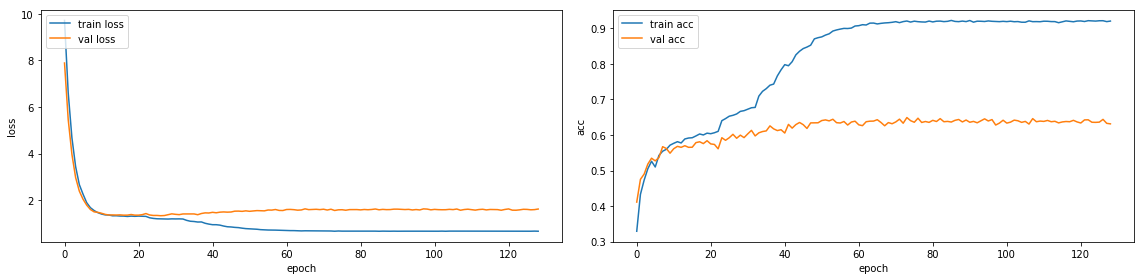

In [38]:
cp_name = './Model/1st_place_kernelreg0.001_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.001)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(data_formatted, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

## kernel_reg0.0055, featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 5s - loss: 23.7954 - acc: 0.3233 - val_loss: 5.9840 - val_acc: 0.3892
Epoch 2/1000
112/112 [==============================] - 4s - loss: 3.1508 - acc: 0.3900 - val_loss: 1.9237 - val_acc: 0.4082
Epoch 3/1000
112/112 [==============================] - 4s - loss: 1.7542 - acc: 0.4084 - val_loss: 1.6705 - val_acc: 0.3911
Epoch 4/1000
112/112 [==============================] - 4s - loss: 1.6600 - acc: 0.4143 - val_loss: 1.6019 - val_acc: 0.4586
Epoch 5/1000
112/112 [==============================] - 4s - loss: 1.6375 - acc: 0.4325 - val_loss: 1.6079 - val_acc: 0.4424
Epoch 6/1000
112/112 [==============================] - 4s - loss: 1.6367 - acc: 0.4388 - val_loss: 1.6287 - val_acc: 0.4403
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.6355 - acc: 0.4445 - val_loss: 1.5982 - val_acc: 0.4508
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.6233 - acc: 0.4507 - val_loss:

112/112 [==============================] - 4s - loss: 1.5386 - acc: 0.4925 - val_loss: 1.5204 - val_acc: 0.4970
Epoch 29/1000
112/112 [==============================] - 4s - loss: 1.5259 - acc: 0.4986 - val_loss: 1.5071 - val_acc: 0.4964
Epoch 30/1000
112/112 [==============================] - 4s - loss: 1.5312 - acc: 0.4991 - val_loss: 1.5330 - val_acc: 0.5021
Epoch 31/1000
112/112 [==============================] - 4s - loss: 1.5295 - acc: 0.4988 - val_loss: 1.5348 - val_acc: 0.5099
Epoch 32/1000
112/112 [==============================] - 4s - loss: 1.5273 - acc: 0.5021 - val_loss: 1.5209 - val_acc: 0.4991
Epoch 33/1000
112/112 [==============================] - 4s - loss: 1.5237 - acc: 0.5020 - val_loss: 1.5432 - val_acc: 0.4919
Epoch 34/1000
112/112 [==============================] - 4s - loss: 1.5357 - acc: 0.4964 - val_loss: 1.5524 - val_acc: 0.4850
Epoch 35/1000
110/112 [============================>.] - ETA: 0s - loss: 1.5281 - acc: 0.5024Epoch 00034: val_loss did not improve



112/112 [==============================] - 4s - loss: 1.4632 - acc: 0.5328 - val_loss: 1.4945 - val_acc: 0.5084
Epoch 57/1000
112/112 [==============================] - 4s - loss: 1.4636 - acc: 0.5321 - val_loss: 1.4659 - val_acc: 0.5318
Epoch 58/1000
112/112 [==============================] - 4s - loss: 1.4640 - acc: 0.5318 - val_loss: 1.4364 - val_acc: 0.5507
Epoch 59/1000
112/112 [==============================] - 4s - loss: 1.4554 - acc: 0.5354 - val_loss: 1.4710 - val_acc: 0.5249
Epoch 60/1000
112/112 [==============================] - 4s - loss: 1.4670 - acc: 0.5356 - val_loss: 1.4603 - val_acc: 0.5348
Epoch 61/1000
112/112 [==============================] - 4s - loss: 1.4585 - acc: 0.5370 - val_loss: 1.4729 - val_acc: 0.5240
Epoch 62/1000
112/112 [==============================] - 4s - loss: 1.4710 - acc: 0.5290 - val_loss: 1.4647 - val_acc: 0.5234
Epoch 63/1000
112/112 [==============================] - 4s - loss: 1.4607 - acc: 0.5332 - val_loss: 1.4735 - val_acc: 0.5243
Epoch 

112/112 [==============================] - 4s - loss: 1.4327 - acc: 0.5477 - val_loss: 1.4413 - val_acc: 0.5414
Epoch 88/1000
112/112 [==============================] - 4s - loss: 1.4240 - acc: 0.5528 - val_loss: 1.4569 - val_acc: 0.5309
Epoch 89/1000
112/112 [==============================] - 4s - loss: 1.4383 - acc: 0.5475 - val_loss: 1.4439 - val_acc: 0.5420
Epoch 90/1000
112/112 [==============================] - 4s - loss: 1.4263 - acc: 0.5502 - val_loss: 1.4413 - val_acc: 0.5360
Epoch 91/1000
112/112 [==============================] - 4s - loss: 1.4368 - acc: 0.5454 - val_loss: 1.4464 - val_acc: 0.5411
Epoch 92/1000
110/112 [============================>.] - ETA: 0s - loss: 1.4303 - acc: 0.5502Epoch 00091: val_loss did not improve

Epoch 00091: reducing learning rate to 0.00019531250291038305.
112/112 [==============================] - 4s - loss: 1.4300 - acc: 0.5497 - val_loss: 1.4395 - val_acc: 0.5453
Epoch 93/1000
112/112 [==============================] - 4s - loss: 1.4322 - 

112/112 [==============================] - 4s - loss: 1.4271 - acc: 0.5510 - val_loss: 1.4476 - val_acc: 0.5381
Epoch 119/1000
112/112 [==============================] - 4s - loss: 1.4288 - acc: 0.5509 - val_loss: 1.4345 - val_acc: 0.5411
Epoch 120/1000
112/112 [==============================] - 4s - loss: 1.4276 - acc: 0.5486 - val_loss: 1.4339 - val_acc: 0.5474
Epoch 121/1000
112/112 [==============================] - 4s - loss: 1.4266 - acc: 0.5506 - val_loss: 1.4549 - val_acc: 0.5345
Epoch 122/1000
110/112 [============================>.] - ETA: 0s - loss: 1.4291 - acc: 0.5502Epoch 00121: val_loss did not improve

Epoch 00121: reducing learning rate to 2.441406286379788e-05.
112/112 [==============================] - 4s - loss: 1.4298 - acc: 0.5496 - val_loss: 1.4432 - val_acc: 0.5387
Epoch 123/1000
112/112 [==============================] - 4s - loss: 1.4303 - acc: 0.5505 - val_loss: 1.4400 - val_acc: 0.5474
Epoch 124/1000
112/112 [==============================] - 4s - loss: 1.42

112/112 [==============================] - 4s - loss: 1.4308 - acc: 0.5471 - val_loss: 1.4309 - val_acc: 0.5441
Epoch 150/1000
112/112 [==============================] - 4s - loss: 1.4305 - acc: 0.5504 - val_loss: 1.4273 - val_acc: 0.5444
Epoch 151/1000
112/112 [==============================] - 4s - loss: 1.4282 - acc: 0.5507 - val_loss: 1.4316 - val_acc: 0.5474
Epoch 152/1000
110/112 [============================>.] - ETA: 0s - loss: 1.4271 - acc: 0.5504Epoch 00151: val_loss did not improve

Epoch 00151: reducing learning rate to 7.629394644936838e-07.
112/112 [==============================] - 4s - loss: 1.4260 - acc: 0.5508 - val_loss: 1.4599 - val_acc: 0.5297
Epoch 153/1000
112/112 [==============================] - 4s - loss: 1.4300 - acc: 0.5502 - val_loss: 1.4322 - val_acc: 0.5489
Epoch 154/1000
112/112 [==============================] - 4s - loss: 1.4269 - acc: 0.5483 - val_loss: 1.4353 - val_acc: 0.5405
Epoch 155/1000
112/112 [==============================] - 4s - loss: 1.42

112/112 [==============================] - 4s - loss: 1.4256 - acc: 0.5514 - val_loss: 1.4479 - val_acc: 0.5351
Epoch 183/1000
112/112 [==============================] - 4s - loss: 1.4297 - acc: 0.5543 - val_loss: 1.4328 - val_acc: 0.5456
Epoch 184/1000
112/112 [==============================] - 4s - loss: 1.4312 - acc: 0.5492 - val_loss: 1.4540 - val_acc: 0.5408
Epoch 185/1000
112/112 [==============================] - 4s - loss: 1.4260 - acc: 0.5517 - val_loss: 1.4370 - val_acc: 0.5405
Epoch 186/1000
112/112 [==============================] - 4s - loss: 1.4225 - acc: 0.5510 - val_loss: 1.4646 - val_acc: 0.5318
Epoch 187/1000
112/112 [==============================] - 4s - loss: 1.4339 - acc: 0.5450 - val_loss: 1.4483 - val_acc: 0.5393
Epoch 188/1000
112/112 [==============================] - 4s - loss: 1.4199 - acc: 0.5548 - val_loss: 1.4451 - val_acc: 0.5351
Epoch 189/1000
112/112 [==============================] - 4s - loss: 1.4344 - acc: 0.5477 - val_loss: 1.4430 - val_acc: 0.5321

112/112 [==============================] - 4s - loss: 1.4264 - acc: 0.5517 - val_loss: 1.4423 - val_acc: 0.5414
Epoch 216/1000
112/112 [==============================] - 4s - loss: 1.4286 - acc: 0.5551 - val_loss: 1.4327 - val_acc: 0.5423
Epoch 217/1000
112/112 [==============================] - 4s - loss: 1.4303 - acc: 0.5503 - val_loss: 1.4408 - val_acc: 0.5432
Epoch 218/1000
112/112 [==============================] - 4s - loss: 1.4315 - acc: 0.5496 - val_loss: 1.4397 - val_acc: 0.5393
Epoch 219/1000
112/112 [==============================] - 4s - loss: 1.4270 - acc: 0.5507 - val_loss: 1.4237 - val_acc: 0.5501
Epoch 220/1000
112/112 [==============================] - 4s - loss: 1.4275 - acc: 0.5486 - val_loss: 1.4402 - val_acc: 0.5420
Epoch 221/1000
112/112 [==============================] - 4s - loss: 1.4266 - acc: 0.5498 - val_loss: 1.4593 - val_acc: 0.5303
Epoch 222/1000
112/112 [==============================] - 4s - loss: 1.4259 - acc: 0.5519 - val_loss: 1.4406 - val_acc: 0.5416

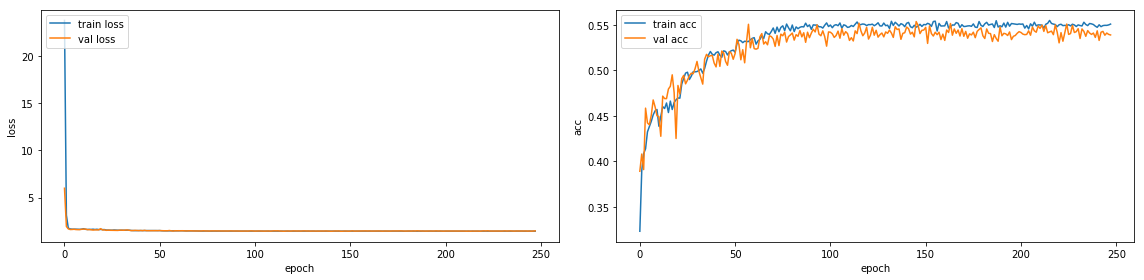

In [29]:
cp_name = './Model/1st_place_kernelreg0.0055_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.0055)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(data_formatted, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

## kernel_reg0.00325, featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 4s - loss: 19.5976 - acc: 0.3265 - val_loss: 9.1904 - val_acc: 0.4076
Epoch 2/1000
112/112 [==============================] - 4s - loss: 5.4845 - acc: 0.4196 - val_loss: 3.1656 - val_acc: 0.4514
Epoch 3/1000
112/112 [==============================] - 4s - loss: 2.3936 - acc: 0.4486 - val_loss: 1.8823 - val_acc: 0.4628
Epoch 4/1000
112/112 [==============================] - 4s - loss: 1.7049 - acc: 0.4783 - val_loss: 1.5862 - val_acc: 0.4904
Epoch 5/1000
112/112 [==============================] - 4s - loss: 1.5627 - acc: 0.4870 - val_loss: 1.5058 - val_acc: 0.4886
Epoch 6/1000
112/112 [==============================] - 4s - loss: 1.5625 - acc: 0.4811 - val_loss: 1.5071 - val_acc: 0.4961
Epoch 7/1000
112/112 [==============================] - 4s - loss: 1.5019 - acc: 0.5042 - val_loss: 1.4889 - val_acc: 0.5078
Epoch 8/1000
112/112 [==============================] - 4s - loss: 1.5066 - acc: 0.5032 - val_loss:

112/112 [==============================] - 4s - loss: 1.4976 - acc: 0.5129 - val_loss: 1.4806 - val_acc: 0.5168
Epoch 28/1000
112/112 [==============================] - 4s - loss: 1.4792 - acc: 0.5203 - val_loss: 1.4858 - val_acc: 0.5210
Epoch 29/1000
112/112 [==============================] - 4s - loss: 1.4836 - acc: 0.5210 - val_loss: 1.4439 - val_acc: 0.5387
Epoch 30/1000
112/112 [==============================] - 4s - loss: 1.4818 - acc: 0.5194 - val_loss: 1.5512 - val_acc: 0.4910
Epoch 31/1000
112/112 [==============================] - 4s - loss: 1.4902 - acc: 0.5173 - val_loss: 1.4811 - val_acc: 0.5117
Epoch 32/1000
112/112 [==============================] - 4s - loss: 1.4772 - acc: 0.5251 - val_loss: 1.4751 - val_acc: 0.5222
Epoch 33/1000
112/112 [==============================] - 4s - loss: 1.4957 - acc: 0.5149 - val_loss: 1.4894 - val_acc: 0.5015
Epoch 34/1000
112/112 [==============================] - 4s - loss: 1.4962 - acc: 0.5228 - val_loss: 1.4865 - val_acc: 0.5147
Epoch 

112/112 [==============================] - 4s - loss: 1.3665 - acc: 0.5703 - val_loss: 1.3954 - val_acc: 0.5498
Epoch 57/1000
112/112 [==============================] - 4s - loss: 1.3699 - acc: 0.5633 - val_loss: 1.4224 - val_acc: 0.5336
Epoch 58/1000
110/112 [============================>.] - ETA: 0s - loss: 1.3709 - acc: 0.5678Epoch 00057: val_loss did not improve

Epoch 00057: reducing learning rate to 0.012500000186264515.
112/112 [==============================] - 4s - loss: 1.3707 - acc: 0.5678 - val_loss: 1.3868 - val_acc: 0.5513
Epoch 59/1000
112/112 [==============================] - 4s - loss: 1.3413 - acc: 0.5792 - val_loss: 1.3708 - val_acc: 0.5543
Epoch 60/1000
112/112 [==============================] - 4s - loss: 1.3447 - acc: 0.5766 - val_loss: 1.3803 - val_acc: 0.5540
Epoch 61/1000
112/112 [==============================] - 4s - loss: 1.3362 - acc: 0.5804 - val_loss: 1.3722 - val_acc: 0.5588
Epoch 62/1000
112/112 [==============================] - 4s - loss: 1.3376 - ac

112/112 [==============================] - 4s - loss: 1.3090 - acc: 0.5957 - val_loss: 1.3616 - val_acc: 0.5651
Epoch 86/1000
112/112 [==============================] - 4s - loss: 1.3065 - acc: 0.5998 - val_loss: 1.3409 - val_acc: 0.5777
Epoch 87/1000
112/112 [==============================] - 4s - loss: 1.3102 - acc: 0.5948 - val_loss: 1.3543 - val_acc: 0.5723
Epoch 88/1000
112/112 [==============================] - 4s - loss: 1.3093 - acc: 0.5976 - val_loss: 1.3561 - val_acc: 0.5639
Epoch 89/1000
112/112 [==============================] - 4s - loss: 1.3028 - acc: 0.5981 - val_loss: 1.3637 - val_acc: 0.5606
Epoch 90/1000
112/112 [==============================] - 4s - loss: 1.3060 - acc: 0.5993 - val_loss: 1.3566 - val_acc: 0.5720
Epoch 91/1000
112/112 [==============================] - 4s - loss: 1.3045 - acc: 0.5971 - val_loss: 1.3618 - val_acc: 0.5621
Epoch 92/1000
111/112 [============================>.] - ETA: 0s - loss: 1.3038 - acc: 0.5978Epoch 00091: val_loss did not improve



112/112 [==============================] - 4s - loss: 1.2945 - acc: 0.6030 - val_loss: 1.3501 - val_acc: 0.5738
Epoch 116/1000
112/112 [==============================] - 4s - loss: 1.2920 - acc: 0.6054 - val_loss: 1.3515 - val_acc: 0.5672
Epoch 117/1000
112/112 [==============================] - 4s - loss: 1.2933 - acc: 0.6050 - val_loss: 1.3361 - val_acc: 0.5708
Epoch 118/1000
112/112 [==============================] - 4s - loss: 1.2930 - acc: 0.6048 - val_loss: 1.3366 - val_acc: 0.5774
Epoch 119/1000
110/112 [============================>.] - ETA: 0s - loss: 1.2939 - acc: 0.6040Epoch 00118: val_loss did not improve

Epoch 00118: reducing learning rate to 0.00019531250291038305.
112/112 [==============================] - 4s - loss: 1.2937 - acc: 0.6046 - val_loss: 1.3494 - val_acc: 0.5666
Epoch 120/1000
112/112 [==============================] - 4s - loss: 1.2977 - acc: 0.6029 - val_loss: 1.3453 - val_acc: 0.5669
Epoch 121/1000
112/112 [==============================] - 4s - loss: 1.2

112/112 [==============================] - 4s - loss: 1.2956 - acc: 0.6011 - val_loss: 1.3442 - val_acc: 0.5705
Epoch 148/1000
112/112 [==============================] - 4s - loss: 1.2877 - acc: 0.6047 - val_loss: 1.3526 - val_acc: 0.5645
Epoch 149/1000
111/112 [============================>.] - ETA: 0s - loss: 1.2839 - acc: 0.6109Epoch 00148: val_loss did not improve

Epoch 00148: reducing learning rate to 3.051757857974735e-06.
112/112 [==============================] - 4s - loss: 1.2843 - acc: 0.6103 - val_loss: 1.3467 - val_acc: 0.5717
Epoch 150/1000
112/112 [==============================] - 4s - loss: 1.2891 - acc: 0.6057 - val_loss: 1.3470 - val_acc: 0.5777
Epoch 151/1000
112/112 [==============================] - 4s - loss: 1.2887 - acc: 0.6040 - val_loss: 1.3348 - val_acc: 0.5774
Epoch 152/1000
112/112 [==============================] - 4s - loss: 1.2938 - acc: 0.6022 - val_loss: 1.3483 - val_acc: 0.5729
Epoch 153/1000
112/112 [==============================] - 4s - loss: 1.29

112/112 [==============================] - 4s - loss: 1.2949 - acc: 0.6049 - val_loss: 1.3393 - val_acc: 0.5636
Epoch 180/1000
110/112 [============================>.] - ETA: 0s - loss: 1.2946 - acc: 0.6014Epoch 00179: val_loss did not improve

Epoch 00179: reducing learning rate to 1e-07.
112/112 [==============================] - 4s - loss: 1.2941 - acc: 0.6018 - val_loss: 1.3446 - val_acc: 0.5747
Epoch 181/1000
112/112 [==============================] - 4s - loss: 1.2863 - acc: 0.6079 - val_loss: 1.3586 - val_acc: 0.5639
Epoch 182/1000
112/112 [==============================] - 4s - loss: 1.2995 - acc: 0.5994 - val_loss: 1.3474 - val_acc: 0.5702
Epoch 183/1000
112/112 [==============================] - 4s - loss: 1.2910 - acc: 0.6038 - val_loss: 1.3470 - val_acc: 0.5726
Epoch 184/1000
112/112 [==============================] - 4s - loss: 1.2887 - acc: 0.6070 - val_loss: 1.3376 - val_acc: 0.5699
Epoch 185/1000
112/112 [==============================] - 4s - loss: 1.2906 - acc: 0.6035

112/112 [==============================] - 4s - loss: 1.2923 - acc: 0.6028 - val_loss: 1.3405 - val_acc: 0.5711
Epoch 213/1000
112/112 [==============================] - 4s - loss: 1.2880 - acc: 0.6046 - val_loss: 1.3428 - val_acc: 0.5744
Epoch 214/1000
112/112 [==============================] - 4s - loss: 1.2898 - acc: 0.6046 - val_loss: 1.3418 - val_acc: 0.5777
Epoch 215/1000
112/112 [==============================] - 4s - loss: 1.2927 - acc: 0.6017 - val_loss: 1.3527 - val_acc: 0.5711
Epoch 216/1000
112/112 [==============================] - 4s - loss: 1.2925 - acc: 0.6063 - val_loss: 1.3368 - val_acc: 0.5735
Epoch 217/1000
112/112 [==============================] - 4s - loss: 1.2905 - acc: 0.6049 - val_loss: 1.3411 - val_acc: 0.5747
Epoch 218/1000
112/112 [==============================] - 4s - loss: 1.2892 - acc: 0.6053 - val_loss: 1.3471 - val_acc: 0.5669
Epoch 219/1000
112/112 [==============================] - 4s - loss: 1.2948 - acc: 0.6041 - val_loss: 1.3617 - val_acc: 0.5684

112/112 [==============================] - 4s - loss: 1.2872 - acc: 0.6059 - val_loss: 1.3436 - val_acc: 0.5696
Epoch 247/1000
112/112 [==============================] - 4s - loss: 1.2925 - acc: 0.6029 - val_loss: 1.3299 - val_acc: 0.5750
Epoch 248/1000
112/112 [==============================] - 4s - loss: 1.2859 - acc: 0.6087 - val_loss: 1.3481 - val_acc: 0.5711
Epoch 249/1000
112/112 [==============================] - 4s - loss: 1.2969 - acc: 0.6016 - val_loss: 1.3526 - val_acc: 0.5627
Epoch 250/1000
112/112 [==============================] - 4s - loss: 1.2910 - acc: 0.6063 - val_loss: 1.3444 - val_acc: 0.5702
Epoch 251/1000
112/112 [==============================] - 4s - loss: 1.2877 - acc: 0.6052 - val_loss: 1.3431 - val_acc: 0.5669
Epoch 252/1000
112/112 [==============================] - 4s - loss: 1.2993 - acc: 0.6012 - val_loss: 1.3444 - val_acc: 0.5720
Epoch 253/1000
112/112 [==============================] - 4s - loss: 1.2874 - acc: 0.6045 - val_loss: 1.3321 - val_acc: 0.5789

112/112 [==============================] - 4s - loss: 1.2813 - acc: 0.6080 - val_loss: 1.3531 - val_acc: 0.5591
Epoch 279/1000
112/112 [==============================] - 4s - loss: 1.2931 - acc: 0.6054 - val_loss: 1.3443 - val_acc: 0.5720
Epoch 280/1000
112/112 [==============================] - 4s - loss: 1.2909 - acc: 0.6047 - val_loss: 1.3385 - val_acc: 0.5741
Epoch 281/1000
112/112 [==============================] - 4s - loss: 1.2901 - acc: 0.6022 - val_loss: 1.3458 - val_acc: 0.5699
Epoch 282/1000
112/112 [==============================] - 4s - loss: 1.2911 - acc: 0.6051 - val_loss: 1.3385 - val_acc: 0.5732
Epoch 283/1000
112/112 [==============================] - 4s - loss: 1.2910 - acc: 0.6059 - val_loss: 1.3365 - val_acc: 0.5711
Epoch 284/1000
112/112 [==============================] - 4s - loss: 1.2881 - acc: 0.6048 - val_loss: 1.3503 - val_acc: 0.5666
Epoch 285/1000
112/112 [==============================] - 4s - loss: 1.2974 - acc: 0.6037 - val_loss: 1.3449 - val_acc: 0.5750

112/112 [==============================] - 4s - loss: 1.2952 - acc: 0.6012 - val_loss: 1.3313 - val_acc: 0.5735
Epoch 313/1000
112/112 [==============================] - 4s - loss: 1.2819 - acc: 0.6087 - val_loss: 1.3426 - val_acc: 0.5708
Epoch 314/1000
112/112 [==============================] - 4s - loss: 1.2929 - acc: 0.6004 - val_loss: 1.3470 - val_acc: 0.5777
Epoch 315/1000
112/112 [==============================] - 4s - loss: 1.2944 - acc: 0.6045 - val_loss: 1.3352 - val_acc: 0.5744
Epoch 316/1000
112/112 [==============================] - 4s - loss: 1.2842 - acc: 0.6060 - val_loss: 1.3315 - val_acc: 0.5777
Epoch 317/1000
112/112 [==============================] - 4s - loss: 1.2981 - acc: 0.6025 - val_loss: 1.3542 - val_acc: 0.5669
Epoch 318/1000
112/112 [==============================] - 4s - loss: 1.2943 - acc: 0.6032 - val_loss: 1.3578 - val_acc: 0.5687
Epoch 319/1000
112/112 [==============================] - 4s - loss: 1.2900 - acc: 0.6018 - val_loss: 1.3428 - val_acc: 0.5717

112/112 [==============================] - 4s - loss: 1.2911 - acc: 0.6057 - val_loss: 1.3478 - val_acc: 0.5741
Epoch 346/1000
112/112 [==============================] - 4s - loss: 1.2858 - acc: 0.6067 - val_loss: 1.3461 - val_acc: 0.5708
Epoch 347/1000
112/112 [==============================] - 4s - loss: 1.2924 - acc: 0.6045 - val_loss: 1.3606 - val_acc: 0.5591
Epoch 348/1000
112/112 [==============================] - 4s - loss: 1.2880 - acc: 0.6045 - val_loss: 1.3377 - val_acc: 0.5741
Epoch 349/1000
112/112 [==============================] - 4s - loss: 1.2890 - acc: 0.6073 - val_loss: 1.3494 - val_acc: 0.5687
Epoch 350/1000
112/112 [==============================] - 4s - loss: 1.2899 - acc: 0.6053 - val_loss: 1.3361 - val_acc: 0.5771
Epoch 351/1000
112/112 [==============================] - 4s - loss: 1.2978 - acc: 0.5997 - val_loss: 1.3469 - val_acc: 0.5714
Epoch 352/1000
112/112 [==============================] - 4s - loss: 1.2898 - acc: 0.6053 - val_loss: 1.3265 - val_acc: 0.5753

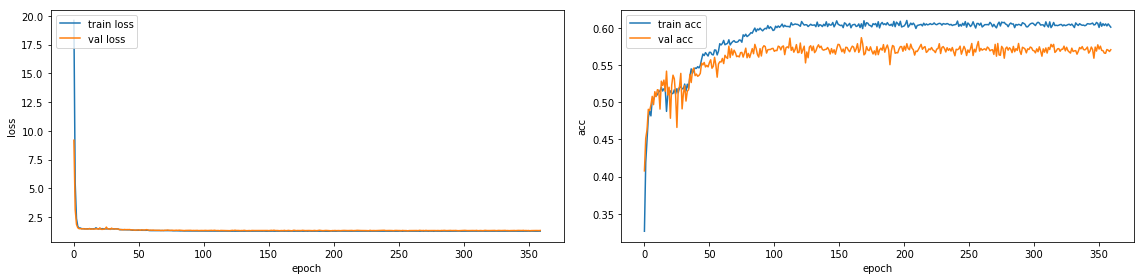

In [31]:
cp_name = './Model/1st_place_kernelreg0.00325_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
kernel_regularizer=regularizers.l2(0.00325)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , kernel_regularizer=kernel_regularizer)

# preprocess data, compile & train model
history = helper.train(data_formatted, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

## batchnorm, featurewise, flip, val_loss, lr_initial=0.1, lr_min=0.0000001, es_patience=101

c:\users\my hoang nguyen\appdata\local\programs\python\python36\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (28698, 48, 48, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Start learning rate: 0.1
Epoch 1/1000
112/112 [==============================] - 7s - loss: 13.2903 - acc: 0.1684 - val_loss: 13.1859 - val_acc: 0.1819
Epoch 2/1000
112/112 [==============================] - 6s - loss: 13.4083 - acc: 0.1681 - val_loss: 13.2689 - val_acc: 0.1768
Epoch 3/1000
112/112 [==============================] - 7s - loss: 13.3990 - acc: 0.1687 - val_loss: 13.1770 - val_acc: 0.1825
Epoch 4/1000
112/112 [==============================] - 7s - loss: 13.4024 - acc: 0.1685 - val_loss: 13.0754 - val_acc: 0.1888
Epoch 5/1000
112/112 [==============================] - 6s - loss: 13.3899 - acc: 0.1693 - val_loss: 13.2302 - val_acc: 0.1792
Epoch 6/1000
112/112 [==============================] - 6s - loss: 13.4198 - acc: 0.1674 - val_loss: 13.1859 - val_acc: 0.1819
Epoch 7/1000
112/112 [==============================] - 7s - loss: 13.3994 - acc: 0.1687 - val_loss: 13.3076 - val_acc: 0.1744
Epoch 8/1000
112/112 [==============================] - 6s - loss: 13.4174 - acc: 0.16

110/112 [============================>.] - ETA: 0s - loss: 13.4254 - acc: 0.1671Epoch 00030: val_loss did not improve

Epoch 00030: reducing learning rate to 0.012500000186264515.
112/112 [==============================] - 6s - loss: 13.4178 - acc: 0.1675 - val_loss: 13.1814 - val_acc: 0.1822
Epoch 32/1000
112/112 [==============================] - 6s - loss: 13.4111 - acc: 0.1679 - val_loss: 13.2108 - val_acc: 0.1804
Epoch 33/1000
112/112 [==============================] - 6s - loss: 13.3962 - acc: 0.1689 - val_loss: 13.2689 - val_acc: 0.1768
Epoch 34/1000
112/112 [==============================] - 6s - loss: 13.4263 - acc: 0.1670 - val_loss: 13.1383 - val_acc: 0.1849
Epoch 35/1000
112/112 [==============================] - 6s - loss: 13.3782 - acc: 0.1700 - val_loss: 13.1867 - val_acc: 0.1819
Epoch 36/1000
110/112 [============================>.] - ETA: 0s - loss: 13.4082 - acc: 0.1681Epoch 00035: val_loss did not improve

Epoch 00035: reducing learning rate to 0.0062500000931322575.

112/112 [==============================] - 6s - loss: 13.4236 - acc: 0.1672 - val_loss: 13.1915 - val_acc: 0.1816
Epoch 63/1000
112/112 [==============================] - 6s - loss: 13.3380 - acc: 0.1725 - val_loss: 13.1141 - val_acc: 0.1864
Epoch 64/1000
112/112 [==============================] - 6s - loss: 13.4376 - acc: 0.1663 - val_loss: 13.2737 - val_acc: 0.1765
Epoch 65/1000
112/112 [==============================] - 6s - loss: 13.3884 - acc: 0.1694 - val_loss: 13.2157 - val_acc: 0.1801
Epoch 66/1000
111/112 [============================>.] - ETA: 0s - loss: 13.4001 - acc: 0.1686Epoch 00065: val_loss did not improve

Epoch 00065: reducing learning rate to 9.765625145519152e-05.
112/112 [==============================] - 6s - loss: 13.4021 - acc: 0.1685 - val_loss: 13.1949 - val_acc: 0.1814
Epoch 67/1000
112/112 [==============================] - 6s - loss: 13.3816 - acc: 0.1698 - val_loss: 13.1431 - val_acc: 0.1846
Epoch 68/1000
112/112 [==============================] - 6s - los

112/112 [==============================] - 6s - loss: 13.3772 - acc: 0.1701 - val_loss: 13.1238 - val_acc: 0.1858
Epoch 95/1000
112/112 [==============================] - 6s - loss: 13.4123 - acc: 0.1679 - val_loss: 13.2979 - val_acc: 0.1750
Epoch 96/1000
111/112 [============================>.] - ETA: 0s - loss: 13.4235 - acc: 0.1672Epoch 00095: val_loss did not improve

Epoch 00095: reducing learning rate to 1.5258789289873675e-06.
112/112 [==============================] - 6s - loss: 13.4233 - acc: 0.1672 - val_loss: 13.2205 - val_acc: 0.1798
Epoch 97/1000
112/112 [==============================] - 6s - loss: 13.4105 - acc: 0.1680 - val_loss: 13.2012 - val_acc: 0.1810
Epoch 98/1000
112/112 [==============================] - 6s - loss: 13.3855 - acc: 0.1695 - val_loss: 13.1334 - val_acc: 0.1852
Epoch 99/1000
112/112 [==============================] - 6s - loss: 13.4048 - acc: 0.1683 - val_loss: 13.2302 - val_acc: 0.1792
Epoch 100/1000
112/112 [==============================] - 6s - l

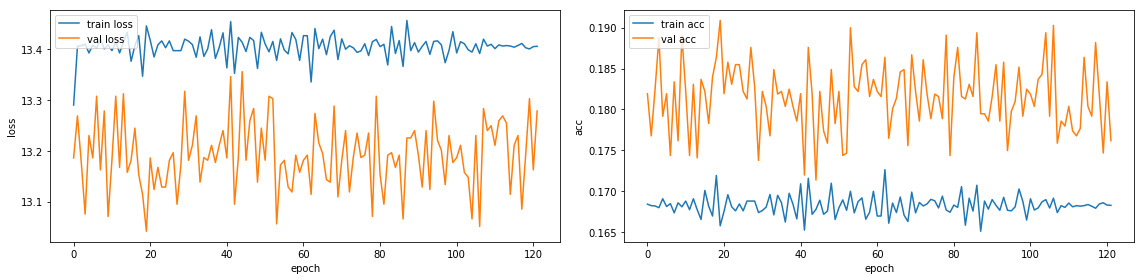

In [32]:
cp_name = './Model/1st_place_batchnorm_featurewise_flip_valloss_lrinitial0.1_lrmin0.0000001_espatience101.hdf5'

# build model
# initializer, regularizer
truncated_normal = TruncatedNormal(seed=1)
# kernel_regularizer=regularizers.l2(0.00325)
model = helper.build_model('1st_place', image_shape, n_classes, truncated_normal
                           , batch_norm=True)

# preprocess data, compile & train model
history = helper.train(data_formatted, n_classes, model, cp_name
                       , lr_initial=0.1, lr_min=1e-07
                       , es_patience=101
                       , epochs=1000)


# visualize metrics
helper.visualize_metrics(history)

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Block1_Crop (Cropping2D)     (None, 42, 42, 1)         0         
_________________________________________________________________
Block1_Conv (Conv2D)         (None, 42, 42, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 42, 42, 32)        128       
_________________________________________________________________
activation_41 (Activation)   (None, 42, 42, 32)        0         
_________________________________________________________________
Block1_Pool (MaxPooling2D)   (None, 21, 21, 32)        0         
_________________________________________________________________
Block2_Pad (ZeroPadding2D)   (None, 23, 23, 32)        0         
_________________________________________________________________
Block2_Conv (Conv2D)         (None, 20, 20, 32)        16416     
__________